# 1. Краткая теория

<a id="1.1"></a>
## 1.1 Описание установки

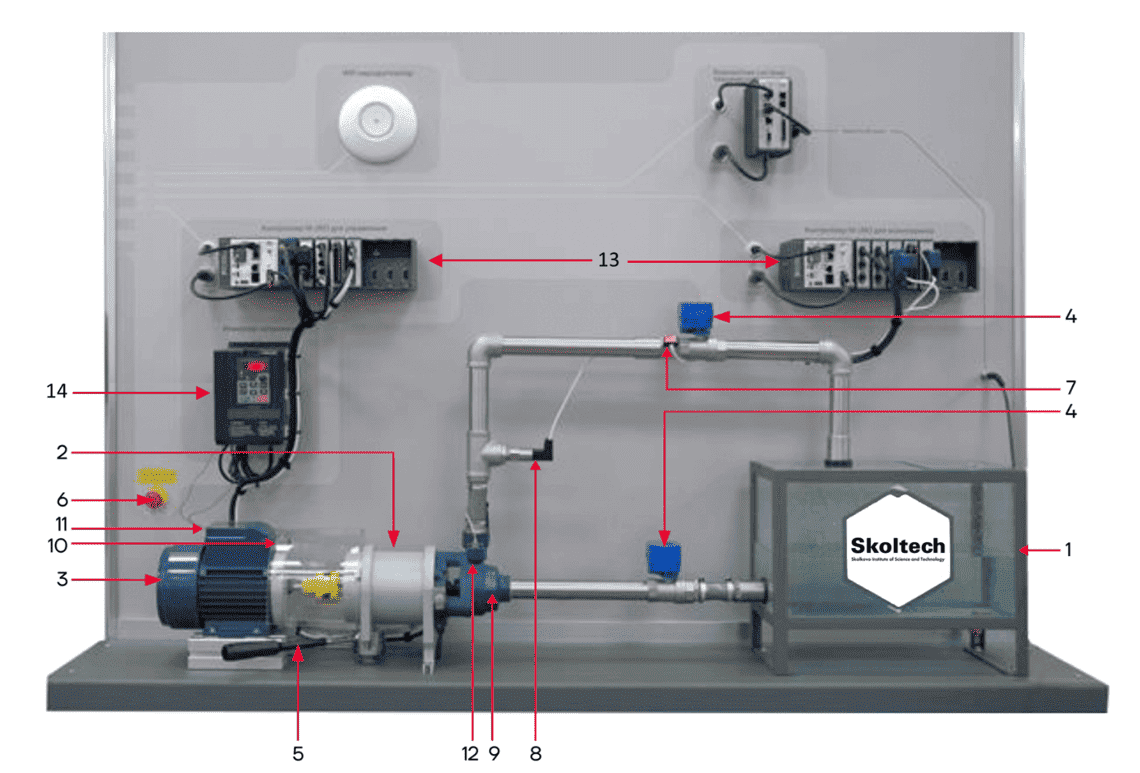

     1 - Резервуар с водой;
     2 - Водяной насос;
     3 - Электродвигатель;
     4 - Электромагнитный клапан;
     5 - Механический рычаг для смещения вала;
     6 - Кнопка аварийной остановки;
     7 – Расходомер;
     8 – Датчик давления;
     9, 10 – Датчик вибрации;
     11, 12 – Датчик температуры;
     13 – Контроллер (ПЛК);
     14 – Инвертор.

    


<a id="1.2"></a>
## 1.2 Бизнес-проблема

К основным преимуществам выявления аномалий в работе оборудования можно отнести:
- Сокращение затрат на обслуживание оборудования
- Оптимизация сроков и продолжительности ремонтных работ
- Уменьшение вероятности отказов


<a id="1.3"></a>
## 1.3 Метрики

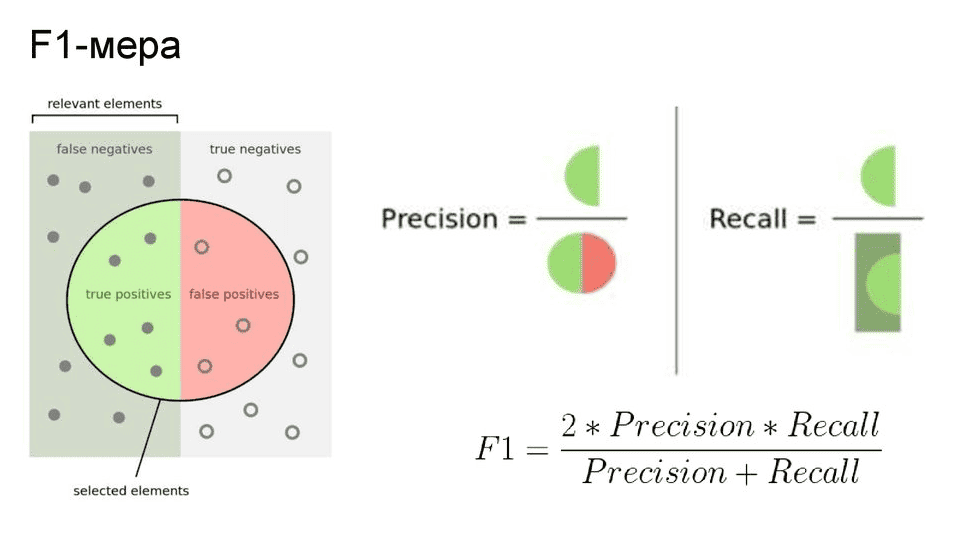

Так как при обнаружении аномалий алгоритмов в первую очередь решается задача классификации, то для оценки качества работы алгоритма предлагается использовать следующую метрику:
- F1-мера (F1-score)
$$F_1 = 2* \frac{precision \cdot recall}{ precision+recall}$$

<a id="1.4"></a>
## 1.4 Описание данных

Каждый файл представляет собой один эксперимент и содержит одну аномалию (исключением является файл anomaly-free, который не содержит ни одной аномалии). Набор данных представляет собой многомерный временной ряд, собранный с датчиков, установленных на испытательном стенде. Папка данных содержит наборы данных из теста. Структура папки данных: 

1. anomaly-free - Данные, полученные из экспериментов с нормальным режимом
2. valve1 - Данные, полученные из экспериментов с закрытием клапана на выходе потока из насоса.

3. valve2 - Данные получены из экспериментов с закрытием клапана на входе потока в насос.

4. other - Данные, полученные из других экспериментов

    1.csv # Моделирование утечек и добавлений жидкости
    
    2.csv # Моделирование утечек и добавлений жидкости
    
    3.csv # Моделирование утечек и добавлений жидкости
    
    4.csv # Моделирование утечек и добавлений жидкости
    
    5.csv # Резкое поведение дисбаланса ротора
    
    6.csv # Линейное поведение дисбаланса ротора
    
    7.csv # Ступенчатое поведение дисбаланса ротора
    
    8.csv # Поведение дельта-функции Дирака дисбаланса ротора
    
    9.csv # Экспоненциальное поведение дисбаланса ротора
    
    10.csv # Медленное увеличение количества воды в контуре
    
    11.csv # Внезапное увеличение количества воды в контуре
    
    12.csv # Слив воды из бака до кавитации
    
    13.csv # Подача двухфазного потока на вход насоса (кавитация)
    
    14.csv # Водоснабжение повышенной температуры

## 1.5 Состав каждого эксперимента

Эксперименты похожи и имеют следующую структуру:

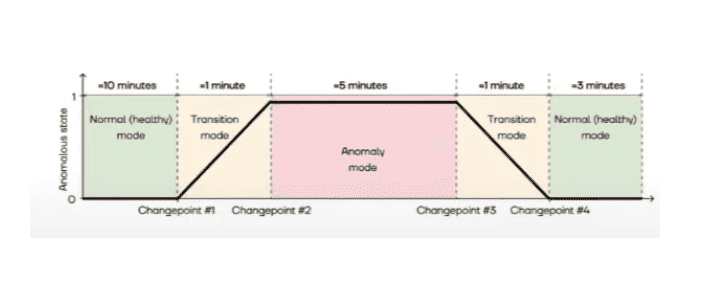

<a id="1.5"></a>
## 1.6 Структура данных 

Столбцы в каждом файле данных следующие:
- Accelerometer1RMS - Виброускорение 
- Accelerometer2RMS - Виброускорение 
- Current - Показывает силу тока на электродвигателе (Ампер)
- Pressure - Представляет собой давление в контуре после водяного насоса (Бар)
- Temperature - Показывает температуру корпуса двигателя (градусы Цельсия)
- Thermocouple - Представляет собой температуру жидкости в циркуляционном контуре (градус Цельсия)
- Voltage - Показывает напряжение на электродвигателе (Вольт)
- RateRMS - Расход циркулирующей жидкости внутри контура (Литр в минуту)
- anomaly - Показывает, является ли точка аномальной (0 или 1)
- changepoint - Показывает, является ли точка точкой изменения состояния (0 или 1)

## 1.7 DS-гипотеза

Мы можем на основании данных (сигналов), полученных с датчиков мониторинга, предсказать аномалии в работе насосного оборудования.

<a id="2"></a>
# 2 Анализ данных

## 2.0 Загрузка библиотек

In [1]:
#! pip install --user pandas numpy matplotlib seaborn scikit-learn xgboost catboost lightgbm 

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn import model_selection, linear_model, metrics
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression,Lasso, Ridge, SGDRegressor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM, SVR
from sklearn.neighbors import KNeighborsRegressor

import evaluating

In [3]:
base_context = 'fivethirtyeight'

# функции для визуализации

def fast_bar(data, figsize=(6, 4), title='', alpha=1, label='', new_figure=True):
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.bar(data.index, data, alpha=alpha, label=label)
        plt.title(title);


def fast_hist(data, n=30, ax=None, figsize=(12, 4), title='', alpha=1, label='', new_figure=True):
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        data.hist(bins=n, ax=ax, figsize=figsize, alpha=alpha, label=label)
        plt.title(title);

        
def fast_plot(data, rolling=1, alpha=0.5, figsize=(12, 4), new_figure=True, title=None, label=None):
    data = data.rolling(rolling).mean()
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.scatter(data.index, data, alpha=alpha)
        plt.plot(data.index, data, linewidth=2, label=label)
        if title is not None:
            plt.title(title)


def fast_scatter(x, y, rolling=1, alpha=0.5, figsize=(12, 4), new_figure=True, title=None, label=None):
    x = x.rolling(rolling).mean()
    y = y.rolling(rolling).mean()
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.scatter(x, y, alpha=alpha, label=label)
        if title is not None:
            plt.title(title)


def fast_legend(ncol=3, pos=(0.5, -0.15), fontsize=16):
    return plt.legend(loc='upper center', ncol=ncol, bbox_to_anchor=pos, fontsize=fontsize)



# функция для построения описательных статистик для экспериментов
def experiment_describe(data, anomaly_type, description, experiment=0):
    start_time = data.index.min()
    finish_time = data.index.max()
    duration = finish_time - start_time
    
    nas = data.isna().sum().sum()
    
    rows = data.shape[0]
    if 'anomaly' in data.columns:
        anomaly_percent = np.round(data['anomaly'].mean() * 100, 2)
        changepoints = data['changepoint'].sum()
    else:
        anomaly_percent = 0
        changepoints = 0  
    
    columns = ['anomaly_type', 'experiment', 'description', 'duration', 'rows', 'anomaly_percent', 'changepoints',
               'Nas', 'start_time', 'finish_time']
    values = np.array([anomaly_type, experiment, description, duration, rows, anomaly_percent, changepoints, nas,
                       start_time, finish_time]).reshape(1, -1)
    
    describe_df = pd.DataFrame(columns=columns, data=values)
    return describe_df


# функция для построения таблицы с информацией по всем экспериментам
def get_summary_table(anomaly_free_data, valve1_data, valve2_data, other_data, other_description):
    df = experiment_describe(anomaly_free_data, 'anomaly_free', 'Нормальный режим')
    
    for experiment in range(len(valve1_data)):
        df = pd.concat([df, experiment_describe(valve1_data[experiment], 'valve1', 
                                                'Закрытие клапана на выходе потока из насоса', experiment)])
        
    for experiment in range(len(valve2_data)):
        df = pd.concat([df, experiment_describe(valve2_data[experiment], 'valve2',
                                                'Закрытие клапана на входе потока в насос', experiment)])
        
    for experiment in range(len(other_data)):
        df = pd.concat([df, experiment_describe(other_data[experiment], 'other', other_description[experiment], experiment)])
    
    df.index = [x for x in range(df.shape[0])]
    return df

<a id="2.1"></a>
## 2.1 Загрузка данных

In [4]:
all_files = []
for root, dirs, files in os.walk("/kaggle/input/ml-cource-cifrum-anomaly-public/data"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')

print("Список файлов:")
all_files.sort()
display(all_files)

Список файлов:


['/kaggle/input/ml-cource-cifrum-anomaly-public/data/anomaly-free/anomaly-free.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/1.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/10.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/11.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/12.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/13.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/14.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/2.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/3.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/4.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/5.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/6.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/7.csv',
 '/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/8.csv',
 '/kaggle/input/ml-cource-cifrum-anomal

In [5]:
other_description = ["Моделирование утечек и добавлений жидкости",
                    "Моделирование утечек и добавлений жидкости",
                    "Моделирование утечек и добавлений жидкости",
                    "Моделирование утечек и добавлений жидкости",
                    "Резкое поведение дисбаланса ротора",
                    "Линейное поведение дисбаланса ротора",
                    "Ступенчатое поведение дисбаланса ротора",
                    "Поведение дельта-функции Дирака дисбаланса ротора",
                    "Экспоненциальное поведение дисбаланса ротора",
                    "Медленное увеличение количества воды в контуре",
                    "Внезапное увеличение количества воды в контуре",
                    "Слив воды из бака до кавитации",
                    "Подача двухфазного потока на вход насоса (кавитация)",
                    "Водоснабжение повышенной температуры"
                    ]



In [6]:
# Группировка данных по типу аномалии
anomaly_free_data = pd.read_csv('/kaggle/input/ml-cource-cifrum-anomaly-public/data/anomaly-free/anomaly-free.csv',
                                sep=';', index_col='datetime', parse_dates=True)
valve1_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve1' in file]
valve2_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve2' in file]
other_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file 
              in all_files if 'other' in file]

In [7]:
# Склеиваем все эксперименты в один список
dfs = [anomaly_free_data] + valve1_data + valve2_data + other_data

In [8]:
# делаем из списка списокв датаферймов один большой датафрейм, в котором эксперименты располагаются друг за другом
alldata = pd.concat(dfs)
alldata = alldata.sort_index()

# 3. Разведочный анализ и подготовка данных

Рассмотрим датасеты по отдельности

## 3.1 Общая информация о датасетах

Переименование колонок датасетов

In [9]:
cols_names = ["Виброускорение1", "Виброускорение2", "Сила тока", "Давление", "Температура корпуса", "Температура жидкости", "Напряжение", "Расход", "Аномалия", "Точка изменения состояния"]

In [10]:
alldata.columns = cols_names
anomaly_free_data.columns = cols_names[:-2]

for n in range(len(valve1_data)):
    valve1_data[n].columns = cols_names


for n in range(len(valve2_data)):
    valve2_data[n].columns = cols_names
    
for n in range(len(other_data)):
    other_data[n].columns = cols_names

In [11]:
display(Markdown('<br>__Количество экспериментов в каждой группе:__'))
print('Экспериментов с закрытием клапана на выходе потока из насоса:', len(valve1_data))
print('Экспериментов с закрытием клапана на входе потока в насос:', len(valve2_data))
print('Других экспериментов:', len(other_data))
print('Датасетов без аномалии: 1')

<br>__Количество экспериментов в каждой группе:__

Экспериментов с закрытием клапана на выходе потока из насоса: 16
Экспериментов с закрытием клапана на входе потока в насос: 4
Других экспериментов: 14
Датасетов без аномалии: 1


Датасет без аномалий

In [12]:
# первые 5 строк
anomaly_free_data.head()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-02-08 13:30:47         0.202394         0.275154    2.16975  0.382638   
2020-02-08 13:30:48         0.203153         0.277857    2.07999 -0.273216   
2020-02-08 13:30:50         0.202054         0.275790    2.52577  0.382638   
2020-02-08 13:30:51         0.203595         0.278101    2.49742  0.054711   
2020-02-08 13:30:52         0.201889         0.276363    2.29194  0.710565   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-02-08 13:30:47              90.6454               26.8508     238.852   
2020-02-08 13:30:48              90.7978               26.8639     227.943   
2020-02-08 13:30:50              90.7730               26.8603     223.486   
2020-02-08 13:30:51              90.8424               26.8616     244.904   
2020-02-08 13:30:52              90.6664               26.8603     239.196   

                      Расход  
datetime                      
2020-02-08 13:30:47  122.664  
2020-02-08 13:30:48  122.338  
2020-02-08 13:30:50  121.338  
2020-02-08 13:30:51  121.664  
2020-02-08 13:30:52  122.000

In [13]:
anomaly_free_data.tail()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-02-08 16:16:43         0.225744         0.267921    2.91598  0.054711   
2020-02-08 16:16:44         0.205870         0.258370    1.71505  0.710565   
2020-02-08 16:16:45         0.219222         0.267244    2.35834 -0.273216   
2020-02-08 16:16:46         0.219481         0.271278    2.49108  0.054711   
2020-02-08 16:16:47         0.219436         0.270046    2.43108  0.382638   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-02-08 16:16:43              88.8593               29.3792     219.542   
2020-02-08 16:16:44              89.1754               29.3692     221.862   
2020-02-08 16:16:45              89.1306               29.3674     226.050   
2020-02-08 16:16:46              88.5447               29.3757     226.343   
2020-02-08 16:16:47              89.1161               29.3687     205.473   

                      Расход  
datetime                      
2020-02-08 16:16:43  126.000  
2020-02-08 16:16:44  126.000  
2020-02-08 16:16:45  126.679  
2020-02-08 16:16:46  127.000  
2020-02-08 16:16:47  125.648

Общая информация о датасете и колонках

In [14]:
anomaly_free_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9405 entries, 2020-02-08 13:30:47 to 2020-02-08 16:16:47
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Виброускорение1       9405 non-null   float64
 1   Виброускорение2       9405 non-null   float64
 2   Сила тока             9405 non-null   float64
 3   Давление              9405 non-null   float64
 4   Температура корпуса   9405 non-null   float64
 5   Температура жидкости  9405 non-null   float64
 6   Напряжение            9405 non-null   float64
 7   Расход                9405 non-null   float64
dtypes: float64(8)
memory usage: 661.3 KB


In [15]:
anomaly_free_data.shape

(9405, 8)

Датасет Valve1

In [16]:
# первые 5 строк (1-ый эксперимент)
valve1_data[0].head()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-03-09 10:14:33         0.026588         0.040111    1.33020  0.054711   
2020-03-09 10:14:34         0.026170         0.040453    1.35399  0.382638   
2020-03-09 10:14:35         0.026199         0.039419    1.54006  0.710565   
2020-03-09 10:14:36         0.026027         0.039641    1.33458  0.382638   
2020-03-09 10:14:37         0.026290         0.040273    1.07851 -0.273216   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-03-09 10:14:33              79.3366               26.0199     233.062   
2020-03-09 10:14:34              79.5158               26.0258     236.040   
2020-03-09 10:14:35              79.3756               26.0265     251.380   
2020-03-09 10:14:36              79.6097               26.0393     234.392   
2020-03-09 10:14:37              79.6109               26.0420     225.342   

                     Расход  Аномалия  Точка изменения состояния  
datetime                                                          
2020-03-09 10:14:33    32.0       0.0                        0.0  
2020-03-09 10:14:34    32.0       0.0                        0.0  
2020-03-09 10:14:35    32.0       0.0                        0.0  
2020-03-09 10:14:36    32.0       0.0                        0.0  
2020-03-09 10:14:37    32.0       0.0                        0.0

В этом датасете появляются еще 2 столбца (anomaly и changepoint)

In [17]:
# последние 5 строк (1-ый эксперимент)
valve1_data[0].tail()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-03-09 10:34:28         0.026789         0.040617    1.46938  0.054711   
2020-03-09 10:34:29         0.027404         0.041474    1.18285 -0.273216   
2020-03-09 10:34:30         0.026981         0.039410    1.19630  0.054711   
2020-03-09 10:34:31         0.027245         0.040391    1.30745  0.054711   
2020-03-09 10:34:32         0.027094         0.039919    1.23944  0.710565   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-03-09 10:34:28              75.6738               25.8363     253.533   
2020-03-09 10:34:29              75.6865               25.8336     205.677   
2020-03-09 10:34:30              75.6305               25.8358     208.907   
2020-03-09 10:34:31              75.7601               25.8363     243.298   
2020-03-09 10:34:32              75.7143               25.8384     228.665   

                      Расход  Аномалия  Точка изменения состояния  
datetime                                                           
2020-03-09 10:34:28  32.0000       0.0                        0.0  
2020-03-09 10:34:29  32.0000       0.0                        0.0  
2020-03-09 10:34:30  32.0000       0.0                        0.0  
2020-03-09 10:34:31  32.9986       0.0                        0.0  
2020-03-09 10:34:32  32.0015       0.0                        0.0

Общая информация о датасете и колонках

In [18]:
valve1_data[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1147 entries, 2020-03-09 10:14:33 to 2020-03-09 10:34:32
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Виброускорение1            1147 non-null   float64
 1   Виброускорение2            1147 non-null   float64
 2   Сила тока                  1147 non-null   float64
 3   Давление                   1147 non-null   float64
 4   Температура корпуса        1147 non-null   float64
 5   Температура жидкости       1147 non-null   float64
 6   Напряжение                 1147 non-null   float64
 7   Расход                     1147 non-null   float64
 8   Аномалия                   1147 non-null   float64
 9   Точка изменения состояния  1147 non-null   float64
dtypes: float64(10)
memory usage: 98.6 KB


In [19]:
valve1_data[0].shape

(1147, 10)

Датасет Valve2

In [20]:
# первые 5 строк (1-ый эксперимент)
valve2_data[0].head()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-03-09 15:56:30         0.027608         0.039203   1.290480  0.054711   
2020-03-09 15:56:31         0.027166         0.039940   1.285650  0.382638   
2020-03-09 15:56:32         0.027718         0.040167   1.155880  0.054711   
2020-03-09 15:56:33         0.028045         0.038026   0.971268  0.382638   
2020-03-09 15:56:34         0.027644         0.038580   1.072460 -0.273216   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-03-09 15:56:30              68.6194               24.3670     241.062   
2020-03-09 15:56:31              68.5923               24.3660     238.709   
2020-03-09 15:56:32              68.5207               24.3666     226.485   
2020-03-09 15:56:33              68.5425               24.3634     220.378   
2020-03-09 15:56:34              68.6569               24.3639     233.922   

                      Расход  Аномалия  Точка изменения состояния  
datetime                                                           
2020-03-09 15:56:30  32.0362       0.0                        0.0  
2020-03-09 15:56:31  32.9649       0.0                        0.0  
2020-03-09 15:56:32  32.0362       0.0                        0.0  
2020-03-09 15:56:33  32.9649       0.0                        0.0  
2020-03-09 15:56:34  32.0000       0.0                        0.0

В этом датасете появляются еще 2 столбца (anomaly и changepoint)

In [21]:
# последние 5 строк (1-ый эксперимент)
valve2_data[0].tail()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-03-09 16:16:25         0.027446         0.039528   0.678398  0.382638   
2020-03-09 16:16:26         0.028101         0.038690   0.858077  0.382638   
2020-03-09 16:16:27         0.028037         0.039878   0.567099  0.054711   
2020-03-09 16:16:28         0.027901         0.042154   0.652006 -0.273216   
2020-03-09 16:16:29         0.027820         0.041096   0.834643  0.054711   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-03-09 16:16:25              67.7144               24.3205     253.086   
2020-03-09 16:16:26              67.7998               24.3226     234.633   
2020-03-09 16:16:27              67.6625               24.3225     224.864   
2020-03-09 16:16:28              67.7782               24.3185     227.674   
2020-03-09 16:16:29              67.7838               24.3152     233.363   

                      Расход  Аномалия  Точка изменения состояния  
datetime                                                           
2020-03-09 16:16:25  32.0000       0.0                        0.0  
2020-03-09 16:16:26  32.0384       0.0                        0.0  
2020-03-09 16:16:27  32.9627       0.0                        0.0  
2020-03-09 16:16:28  32.0000       0.0                        0.0  
2020-03-09 16:16:29  32.0000       0.0                        0.0

Общая информация о датасете и колонках

In [22]:
valve2_data[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1125 entries, 2020-03-09 15:56:30 to 2020-03-09 16:16:29
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Виброускорение1            1125 non-null   float64
 1   Виброускорение2            1125 non-null   float64
 2   Сила тока                  1125 non-null   float64
 3   Давление                   1125 non-null   float64
 4   Температура корпуса        1125 non-null   float64
 5   Температура жидкости       1125 non-null   float64
 6   Напряжение                 1125 non-null   float64
 7   Расход                     1125 non-null   float64
 8   Аномалия                   1125 non-null   float64
 9   Точка изменения состояния  1125 non-null   float64
dtypes: float64(10)
memory usage: 96.7 KB


In [23]:
valve2_data[0].shape

(1125, 10)

In [24]:
# первые 5 строк (1-ый эксперимент)
other_data[0].head()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-03-01 15:44:06         0.082065         0.133521    1.27794  0.054711   
2020-03-01 15:44:07         0.082724         0.132378    1.12118 -0.273216   
2020-03-01 15:44:08         0.081648         0.139038    1.93242  0.054711   
2020-03-01 15:44:09         0.083335         0.132742    1.25962 -0.273216   
2020-03-01 15:44:10         0.082272         0.133171    1.59773  0.054711   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-03-01 15:44:06              92.2562               22.2577     209.639   
2020-03-01 15:44:07              92.0144               22.2577     221.250   
2020-03-01 15:44:08              92.2413               22.2748     236.615   
2020-03-01 15:44:09              92.2438               22.2657     230.375   
2020-03-01 15:44:10              92.3611               22.2591     249.701   

                      Расход  Аномалия  Точка изменения состояния  
datetime                                                           
2020-03-01 15:44:06  76.0197       0.0                        0.0  
2020-03-01 15:44:07  76.9806       0.0                        0.0  
2020-03-01 15:44:08  76.0197       0.0                        0.0  
2020-03-01 15:44:09  77.0000       0.0                        0.0  
2020-03-01 15:44:10  77.0000       0.0                        0.0

В этом датасете появляются еще 2 столбца (anomaly и changepoint)

In [25]:
# последние 5 строк (1-ый эксперимент)
other_data[0].tail()

Виброускорение1  Виброускорение2  Сила тока  Давление  \
datetime                                                                     
2020-03-01 15:57:02         0.080787         0.131610    1.52788 -0.273216   
2020-03-01 15:57:03         0.081003         0.128565    1.78583 -0.273216   
2020-03-01 15:57:04         0.079904         0.133247    1.51095 -0.273216   
2020-03-01 15:57:05         0.080195         0.130859    1.63756  0.054711   
2020-03-01 15:57:06         0.080819         0.128128    1.57362  0.382638   

                     Температура корпуса  Температура жидкости  Напряжение  \
datetime                                                                     
2020-03-01 15:57:02              90.5728               22.2021     237.739   
2020-03-01 15:57:03              90.4393               22.2120     224.866   
2020-03-01 15:57:04              90.6200               22.2098     233.475   
2020-03-01 15:57:05              90.6663               22.2034     227.777   
2020-03-01 15:57:06              90.5676               22.2081     224.993   

                      Расход  Аномалия  Точка изменения состояния  
datetime                                                           
2020-03-01 15:57:02  74.9799       1.0                        0.0  
2020-03-01 15:57:03  74.0000       1.0                        0.0  
2020-03-01 15:57:04  74.0000       1.0                        0.0  
2020-03-01 15:57:05  74.0000       1.0                        0.0  
2020-03-01 15:57:06  74.0000       1.0                        0.0

Общая информация о датасете и колонках

In [26]:
other_data[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 2020-03-01 15:44:06 to 2020-03-01 15:57:06
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Виброускорение1            745 non-null    float64
 1   Виброускорение2            745 non-null    float64
 2   Сила тока                  745 non-null    float64
 3   Давление                   745 non-null    float64
 4   Температура корпуса        745 non-null    float64
 5   Температура жидкости       745 non-null    float64
 6   Напряжение                 745 non-null    float64
 7   Расход                     745 non-null    float64
 8   Аномалия                   745 non-null    float64
 9   Точка изменения состояния  745 non-null    float64
dtypes: float64(10)
memory usage: 64.0 KB


In [27]:
other_data[0].shape

(745, 10)

## 3.2 Количество пустых значений

In [28]:
anomaly_free_data.isna().sum()

Виброускорение1         0
Виброускорение2         0
Сила тока               0
Давление                0
Температура корпуса     0
Температура жидкости    0
Напряжение              0
Расход                  0
dtype: int64

In [29]:
for i in range(len(valve1_data)):
    print("Номер эксперимента: ", i)
    print("Количество пустых значений:", valve1_data[i].isna().sum().sum())
    print("----------------------")

Номер эксперимента:  0
Количество пустых значений: 0
----------------------
Номер эксперимента:  1
Количество пустых значений: 0
----------------------
Номер эксперимента:  2
Количество пустых значений: 0
----------------------
Номер эксперимента:  3
Количество пустых значений: 0
----------------------
Номер эксперимента:  4
Количество пустых значений: 0
----------------------
Номер эксперимента:  5
Количество пустых значений: 0
----------------------
Номер эксперимента:  6
Количество пустых значений: 0
----------------------
Номер эксперимента:  7
Количество пустых значений: 0
----------------------
Номер эксперимента:  8
Количество пустых значений: 0
----------------------
Номер эксперимента:  9
Количество пустых значений: 0
----------------------
Номер эксперимента:  10
Количество пустых значений: 0
----------------------
Номер эксперимента:  11
Количество пустых значений: 0
----------------------
Номер эксперимента:  12
Количество пустых значений: 0
----------------------
Номер экс

In [30]:
for i in range(len(valve2_data)):
    print("Номер эксперимента: ", i)
    print("Количество пустых значений:", valve2_data[i].isna().sum().sum())
    print("----------------------")

Номер эксперимента:  0
Количество пустых значений: 0
----------------------
Номер эксперимента:  1
Количество пустых значений: 0
----------------------
Номер эксперимента:  2
Количество пустых значений: 0
----------------------
Номер эксперимента:  3
Количество пустых значений: 0
----------------------


In [31]:
for i in range(len(other_data)):
    print("Номер эксперимента: ", i)
    print("Количество пустых значений:", other_data[i].isna().sum().sum())
    print("----------------------")

Номер эксперимента:  0
Количество пустых значений: 0
----------------------
Номер эксперимента:  1
Количество пустых значений: 0
----------------------
Номер эксперимента:  2
Количество пустых значений: 0
----------------------
Номер эксперимента:  3
Количество пустых значений: 0
----------------------
Номер эксперимента:  4
Количество пустых значений: 0
----------------------
Номер эксперимента:  5
Количество пустых значений: 0
----------------------
Номер эксперимента:  6
Количество пустых значений: 0
----------------------
Номер эксперимента:  7
Количество пустых значений: 0
----------------------
Номер эксперимента:  8
Количество пустых значений: 0
----------------------
Номер эксперимента:  9
Количество пустых значений: 0
----------------------
Номер эксперимента:  10
Количество пустых значений: 0
----------------------
Номер эксперимента:  11
Количество пустых значений: 0
----------------------
Номер эксперимента:  12
Количество пустых значений: 0
----------------------
Номер экс

Вывод: пустых значений в датасетах по различным экспериментам не обнаружено

**Сводная таблица по всем экспериментам**

In [32]:
summary_table = get_summary_table(anomaly_free_data, valve1_data, valve2_data, other_data, other_description)
display(Markdown('<br>__Сводная таблица по всем экспериментам__<br><br>'))
display(summary_table)

# Склеиваем все эксперименты в один список
dfs = [anomaly_free_data] + valve1_data + valve2_data + other_data

<br>__Сводная таблица по всем экспериментам__<br><br>

anomaly_type experiment  \
0   anomaly_free          0   
1         valve1          0   
2         valve1          1   
3         valve1          2   
4         valve1          3   
5         valve1          4   
6         valve1          5   
7         valve1          6   
8         valve1          7   
9         valve1          8   
10        valve1          9   
11        valve1         10   
12        valve1         11   
13        valve1         12   
14        valve1         13   
15        valve1         14   
16        valve1         15   
17        valve2          0   
18        valve2          1   
19        valve2          2   
20        valve2          3   
21         other          0   
22         other          1   
23         other          2   
24         other          3   
25         other          4   
26         other          5   
27         other          6   
28         other          7   
29         other          8   
30         other          9   
31         other         10   
32         other         11   
33         other         12   
34         other         13   

                                          description        duration  rows  \
0                                    Нормальный режим 0 days 02:46:00  9405   
1         Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1147   
2         Закрытие клапана на выходе потока из насоса 0 days 00:20:00  1145   
3         Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1146   
4         Закрытие клапана на выходе потока из насоса 0 days 00:20:00  1141   
5         Закрытие клапана на выходе потока из насоса 0 days 00:20:00  1140   
6         Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1140   
7         Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1139   
8         Закрытие клапана на выходе потока из насоса 0 days 00:20:00  1150   
9         Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1075   
10        Закрытие клапана на выходе потока из насоса 0 days 00:20:01  1148   
11        Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1095   
12        Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1154   
13        Закрытие клапана на выходе потока из насоса 0 days 00:19:59  1154   
14        Закрытие клапана на выходе потока из насоса 0 days 00:20:00  1094   
15        Закрытие клапана на выходе потока из насоса 0 days 00:19:58  1144   
16        Закрытие клапана на выходе потока из насоса 0 days 00:20:00  1148   
17           Закрытие клапана на входе потока в насос 0 days 00:19:59  1125   
18           Закрытие клапана на входе потока в насос 0 days 00:20:00  1063   
19           Закрытие клапана на входе потока в насос 0 days 00:19:59  1129   
20           Закрытие клапана на входе потока в насос 0 days 00:17:38   995   
21         Моделирование утечек и добавлений жидкости 0 days 00:13:00   745   
22         Моделирование утечек и добавлений жидкости 0 days 00:23:18  1327   
23         Моделирование утечек и добавлений жидкости 0 days 00:20:54  1190   
24         Моделирование утечек и добавлений жидкости 0 days 00:20:03  1048   
25                 Резкое поведение дисбаланса ротора 0 days 00:18:54   923   
26               Линейное поведение дисбаланса ротора 0 days 00:15:51   905   
27            Ступенчатое поведение дисбаланса ротора 0 days 00:17:43   780   
28  Поведение дельта-функции Дирака дисбаланса ротора 0 days 00:19:58  1137   
29       Экспоненциальное поведение дисбаланса ротора 0 days 00:20:56  1191   
30     Медленное увеличение количества воды в контуре 0 days 00:20:08  1155   
31     Внезапное увеличение количества воды в контуре 0 days 00:20:00  1147   
32                     Слив воды из бака до кавитации 0 days 00:19:01  1090   
33  Подача двухфазного потока на вход насоса (кави... 0 days 00:20:02  1147   
34               Водоснабжение повышенной температуры 0 days 00:19:59  1144   

   anomaly_percent changepoints Nas       

__Из данной таблицы можно отметить следующее:__
* Целевое время проведения экспериментов около 20 минут, для anomaly_free время проведения составило 2 часа 46 минут
* Процент времени с аномальным состоянием находится в диапазоне от 25.23% до 50%, но для основной части это значение находится в районе 35%
* Для большинства экспериментов записано 4 точки изменения состояния
* Значения np.NaN в данных отсутствуют
* Эксперименты проводились в следующие даты: 2020-02-08, 2020-03-01, 2020-03-09

В среднем эксперименты длятся в районе 20 минут. Можно отметить, для некоторых экспериментов , что при 20 минутном интервале количество записей, к примеру составляет 1145 - это говорит о том что для некоторых временным меток отсутствуют записи значений.

## 3.3 Дискретность данных

In [33]:
display(Markdown('__Дискретность в датасете без аномалий:__'))
display(anomaly_free_data.index.to_series().diff().value_counts())


__Дискретность в датасете без аномалий:__

datetime
0 days 00:00:01    8848
0 days 00:00:02     556
Name: count, dtype: int64

In [34]:
display(Markdown('__Дискретность в датасете Valve1:__'))
for i in range(len(valve1_data)):
    print("Номер эксперимента: ", i)
    print(valve1_data[i].index.to_series().diff().value_counts())
    print("----------------------")

__Дискретность в датасете Valve1:__

Номер эксперимента:  0
datetime
0 days 00:00:01    1093
0 days 00:00:02      53
Name: count, dtype: int64
----------------------
Номер эксперимента:  1
datetime
0 days 00:00:01    1088
0 days 00:00:02      56
Name: count, dtype: int64
----------------------
Номер эксперимента:  2
datetime
0 days 00:00:01    1091
0 days 00:00:02      54
Name: count, dtype: int64
----------------------
Номер эксперимента:  3
datetime
0 days 00:00:01    1080
0 days 00:00:02      60
Name: count, dtype: int64
----------------------
Номер эксперимента:  4
datetime
0 days 00:00:01    1078
0 days 00:00:02      61
Name: count, dtype: int64
----------------------
Номер эксперимента:  5
datetime
0 days 00:00:01    1079
0 days 00:00:02      60
Name: count, dtype: int64
----------------------
Номер эксперимента:  6
datetime
0 days 00:00:01    1077
0 days 00:00:02      61
Name: count, dtype: int64
----------------------
Номер эксперимента:  7
datetime
0 days 00:00:01    1098
0 days 00:00:02      51
Name: count, dtyp

In [35]:
display(Markdown('__Дискретность в датасете Valve2:__'))
for i in range(len(valve2_data)):
    print("Номер эксперимента: ", i)
    print(valve2_data[i].index.to_series().diff().value_counts())
    print("----------------------")

__Дискретность в датасете Valve2:__

Номер эксперимента:  0
datetime
0 days 00:00:01    1049
0 days 00:00:02      75
Name: count, dtype: int64
----------------------
Номер эксперимента:  1
datetime
0 days 00:00:01    986
0 days 00:00:02     75
0 days 00:01:04      1
Name: count, dtype: int64
----------------------
Номер эксперимента:  2
datetime
0 days 00:00:01    1057
0 days 00:00:02      71
Name: count, dtype: int64
----------------------
Номер эксперимента:  3
datetime
0 days 00:00:01    930
0 days 00:00:02     64
Name: count, dtype: int64
----------------------


In [36]:
display(Markdown('__Дискретность в датасете Other_data:__'))
for i in range(len(other_data)):
    print("Номер эксперимента: ", i)
    print(other_data[i].index.to_series().diff().value_counts())
    print("----------------------")

__Дискретность в датасете Other_data:__

Номер эксперимента:  0
datetime
0 days 00:00:01    708
0 days 00:00:02     36
Name: count, dtype: int64
----------------------
Номер эксперимента:  1
datetime
0 days 00:00:01    1254
0 days 00:00:02      72
Name: count, dtype: int64
----------------------
Номер эксперимента:  2
datetime
0 days 00:00:01    1124
0 days 00:00:02      65
Name: count, dtype: int64
----------------------
Номер эксперимента:  3
datetime
0 days 00:00:01    945
0 days 00:00:02     68
0 days 00:00:03     17
0 days 00:00:04     14
0 days 00:00:05      3
Name: count, dtype: int64
----------------------
Номер эксперимента:  4
datetime
0 days 00:00:01    834
0 days 00:00:02     57
0 days 00:00:03     13
0 days 00:00:04     12
0 days 00:00:05      2
0 days 00:00:33      1
0 days 00:00:19      1
0 days 00:00:21      1
0 days 00:00:16      1
Name: count, dtype: int64
----------------------
Номер эксперимента:  5
datetime
0 days 00:00:01    857
0 days 00:00:02     47
Name: count, dtype: int64
----------------------
Номе

<a id="2.2.3"></a>
## 3.4 Описательные статистики
Для дальнейшего ознакомления с данными можно вывести описательные статистики для одного из экспериментов.
Они включают в себя следующие поля:
* count - количество записей не являющихся пропусками(np.NaN)
* минимальные, средние, максимальные значения, медиану и 25 75 персентили
* стандартное отклонение

In [37]:
display(anomaly_free_data.describe().T)

count        mean        std         min         25%  \
Виброускорение1       9405.0    0.212604   0.004740    0.188217    0.210723   
Виброускорение2       9405.0    0.268407   0.003989    0.248062    0.265510   
Сила тока             9405.0    2.403010   0.486469    0.855284    2.129560   
Давление              9405.0    0.111266   0.253332   -1.257000    0.054711   
Температура корпуса   9405.0   89.472308   0.667109   88.171300   88.954100   
Температура жидкости  9405.0   28.474310   0.730734   26.850800   27.916700   
Напряжение            9405.0  228.647173  10.980578  201.365000  222.623000   
Расход                9405.0  125.237471   1.605327  118.000000  124.000000   

                             50%         75%         max  
Виброускорение1         0.213092    0.215540    0.227198  
Виброускорение2         0.267368    0.271630    0.279921  
Сила тока               2.541890    2.728770    3.241530  
Давление                0.054711    0.382638    1.366420  
Температура корпуса    89.351500   89.861700   91.724900  
Температура жидкости   28.640400   29.113700   29.522100  
Напряжение            228.932000  234.926000  252.806000  
Расход                125.677000  126.328000  128.353000

__Из таблицы можно выделить следующие моменты:__
* Отклонение напряжения достигает 10 единиц.
* Для давления наблюдались отрицательные значения (min = -1.257000)



Для сравнения экспериментов из разных групп можно посчитать среднее значение и стандартные отклонения каждого из параметров

In [38]:
columns = anomaly_free_data.columns
mean_table = pd.DataFrame(index=[x + ' mean' for x in columns])
mean_table['anomaly free'] = anomaly_free_data.describe().loc['mean'].values
mean_table['valve1[0]'] = valve1_data[0][columns].describe().loc['mean'].values
mean_table['valve2[0]'] = valve2_data[0][columns].describe().loc['mean'].values
mean_table['other[0]'] = other_data[0][columns].describe().loc['mean'].values

std_table = pd.DataFrame(index=[x + ' std' for x in columns])
std_table['anomaly free'] = anomaly_free_data.describe().loc['std'].values
std_table['valve1[0]'] = valve1_data[0][columns].describe().loc['std'].values
std_table['valve2[0]'] = valve2_data[0][columns].describe().loc['std'].values
std_table['other[0]'] = other_data[0][columns].describe().loc['std'].values

std_mean_table = pd.concat([mean_table, std_table,])
display(std_mean_table)

anomaly free   valve1[0]   valve2[0]    other[0]
Виброускорение1 mean           0.212604    0.026521    0.027595    0.080549
Виброускорение2 mean           0.268407    0.040174    0.039414    0.131089
Сила тока mean                 2.403010    1.004630    0.971689    1.569378
Давление mean                  0.111266    0.084159    0.038971    0.054711
Температура корпуса mean      89.472308   77.436352   68.759219   92.567708
Температура жидкости mean     28.474310   25.958171   24.329524   22.237863
Напряжение mean              228.647173  230.927635  230.923432  230.246807
Расход mean                  125.237471   32.022679   32.038678   76.157459
Виброускорение1 std            0.004740    0.000329    0.000365    0.001167
Виброускорение2 std            0.003989    0.000774    0.001030    0.003030
Сила тока std                  0.486469    0.268688    0.272406    0.386894
Давление std                   0.253332    0.249567    0.260521    0.270437
Температура корпуса std        0.667109    1.745585    1.442933    1.933215
Температура жидкости std       0.730734    0.078456    0.030782    0.018487
Напряжение std                10.980578   10.748393   10.829161   11.037523
Расход std                     1.605327    0.457728    0.584108    1.155151

__Из данной таблицы можно выделить следующие моменты:__
* Среднее значение виброускорения для anomaly free почти на порядок выше чем для экспериментов с закрытием входных и выходных клапанов (valve1[0], valve2[0])
* Среднее значение расхода воды для anomaly free в 4 раза выше чем для экспериментов с закрытием входных и выходных клапанов (valve1[0], valve2[0])
* Средние значения температуры, давления, тока, термопары для anomaly free выше чем для экспериментов с закрытием входных и выходных клапанов (valve1[0], valve2[0])

<a id="2.2.4"></a>
## 3.5 Пропуски и выбросы в данных, шум
Не всегда пропуски в данных можно определить методом pandas isna(). Пропуски в данных могут обозначаться 0 или другими значениями. Оценим наличие пропусков и выбросов с помощью графиков.

<a id="2.2.4.1"></a>
### 3.5.1 Графики сигналов (данные без аномалий)
Для оценки пропусков, выбросов и шумов выведем графики трендов для каждого сигнала

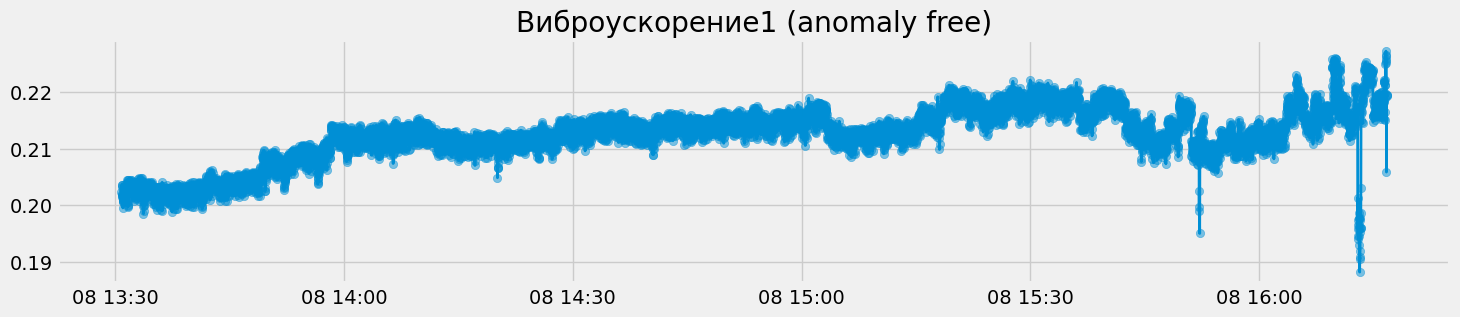

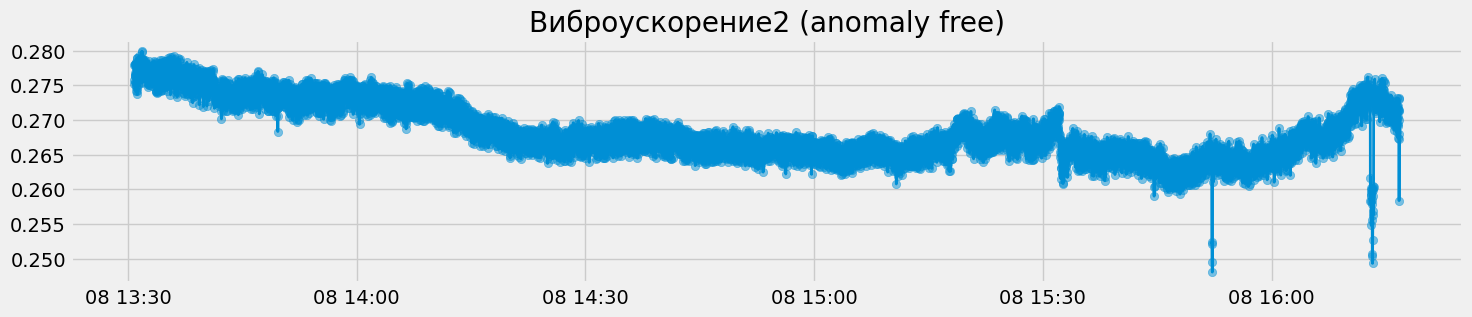

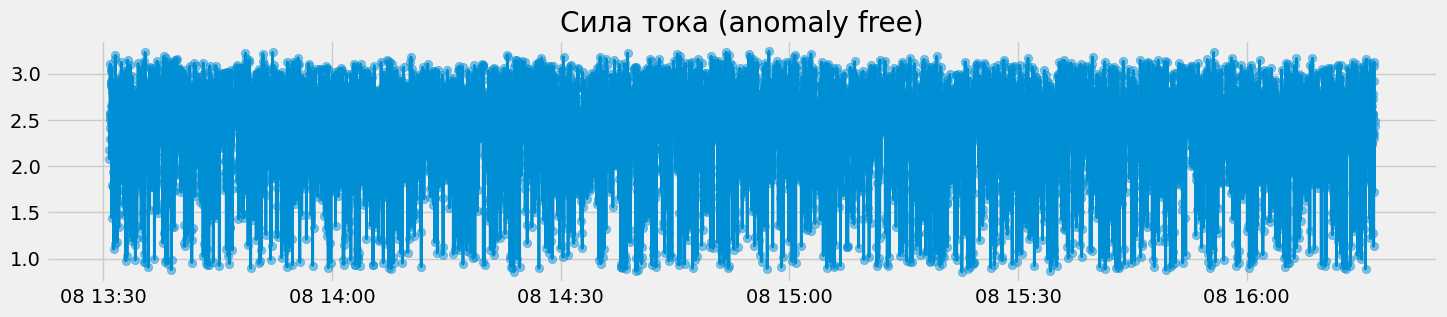

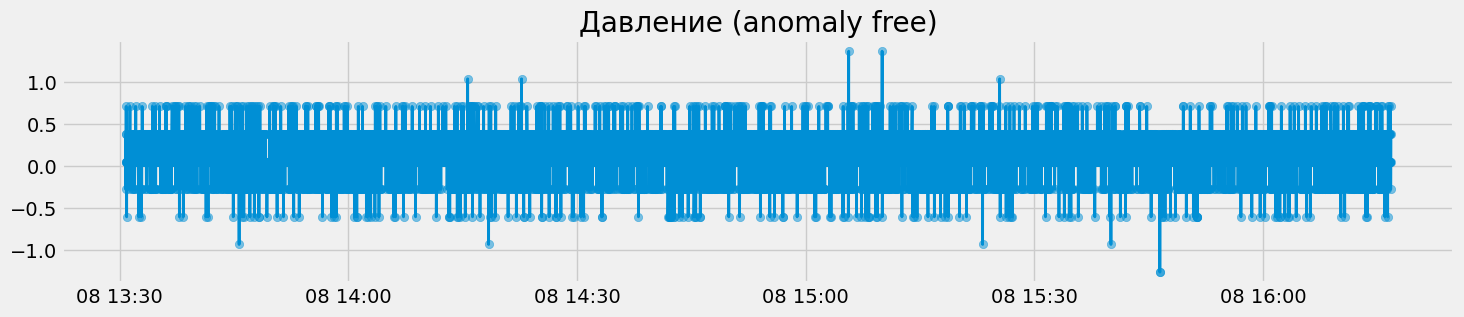

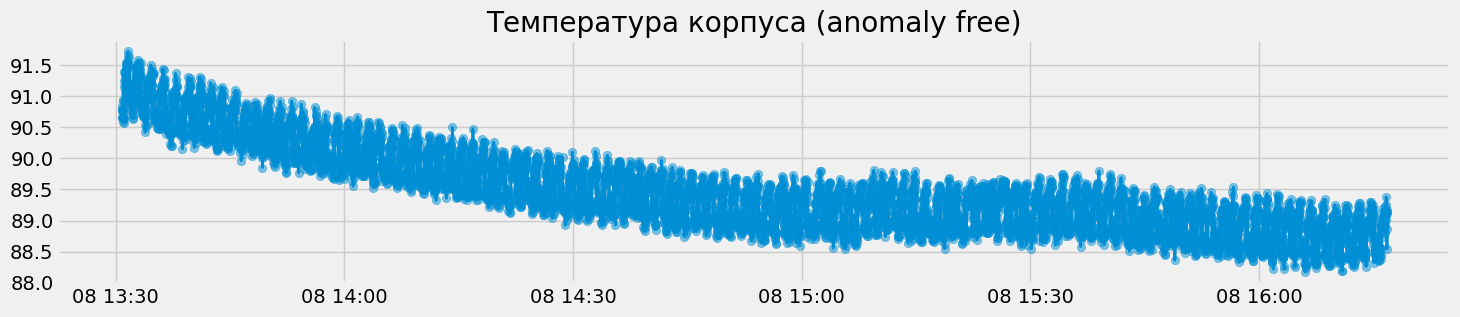

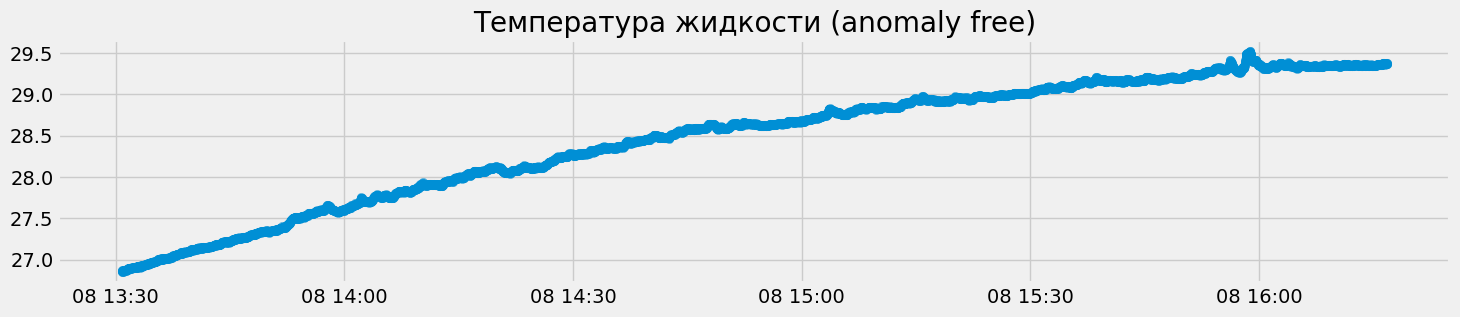

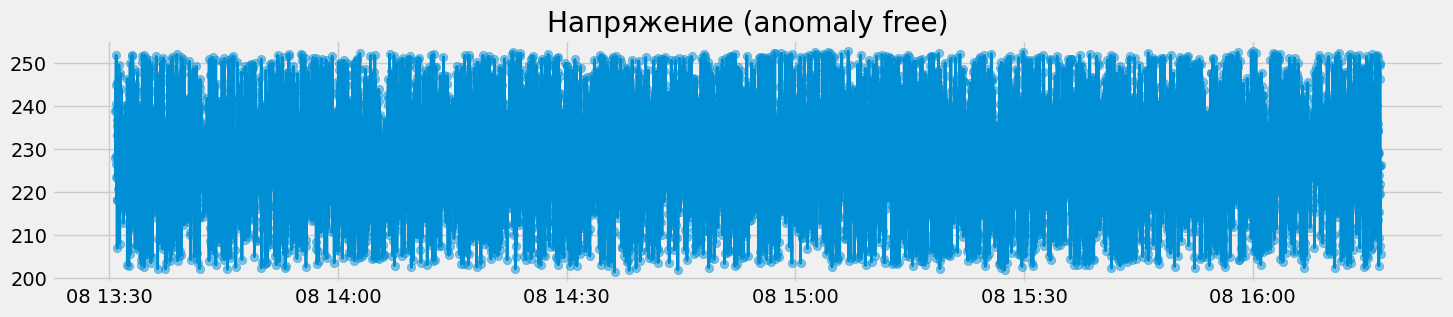

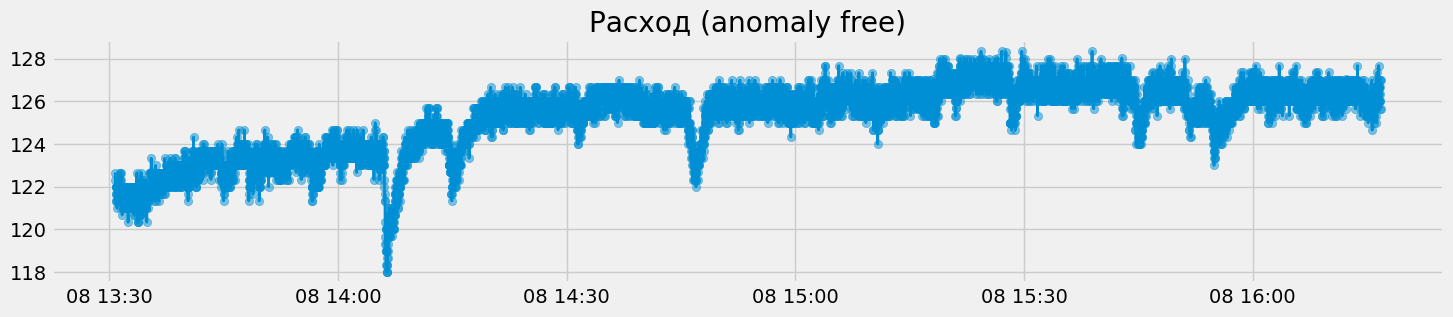

In [39]:
for column in anomaly_free_data.columns:
    fast_plot(anomaly_free_data[column], title=column + ' (anomaly free)', figsize=(16, 3))

На графиках виброускорений и давления наблюдаются  выбросы.

На графиках расхода видны резкие скачки значений вниз.

На графике Температуры жидкости и расхода наблюдается восходящий тренд в течение всего времени эксперимента

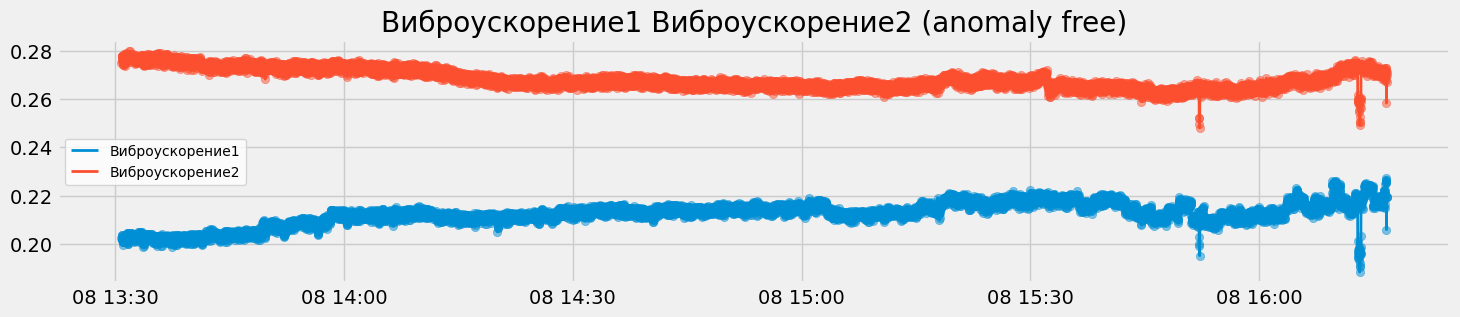

In [40]:
fast_plot(anomaly_free_data['Виброускорение1'], title='Виброускорение1 Виброускорение2 (anomaly free)',label = "Виброускорение1", figsize=(16, 3))
fast_plot(anomaly_free_data['Виброускорение2'], figsize=(14, 3), new_figure=False, label = "Виброускорение2")
plt.legend();

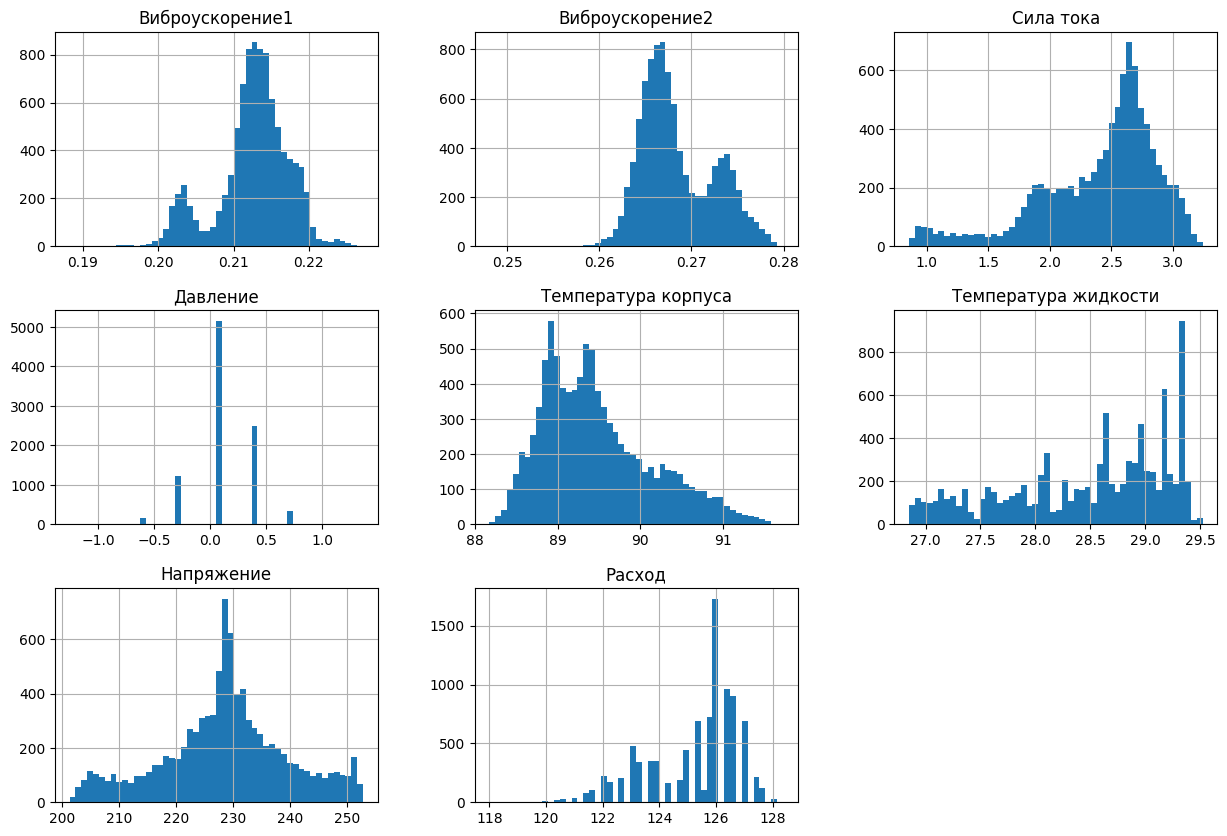

In [41]:
anomaly_free_data.hist(figsize=(15,10), bins = 50);

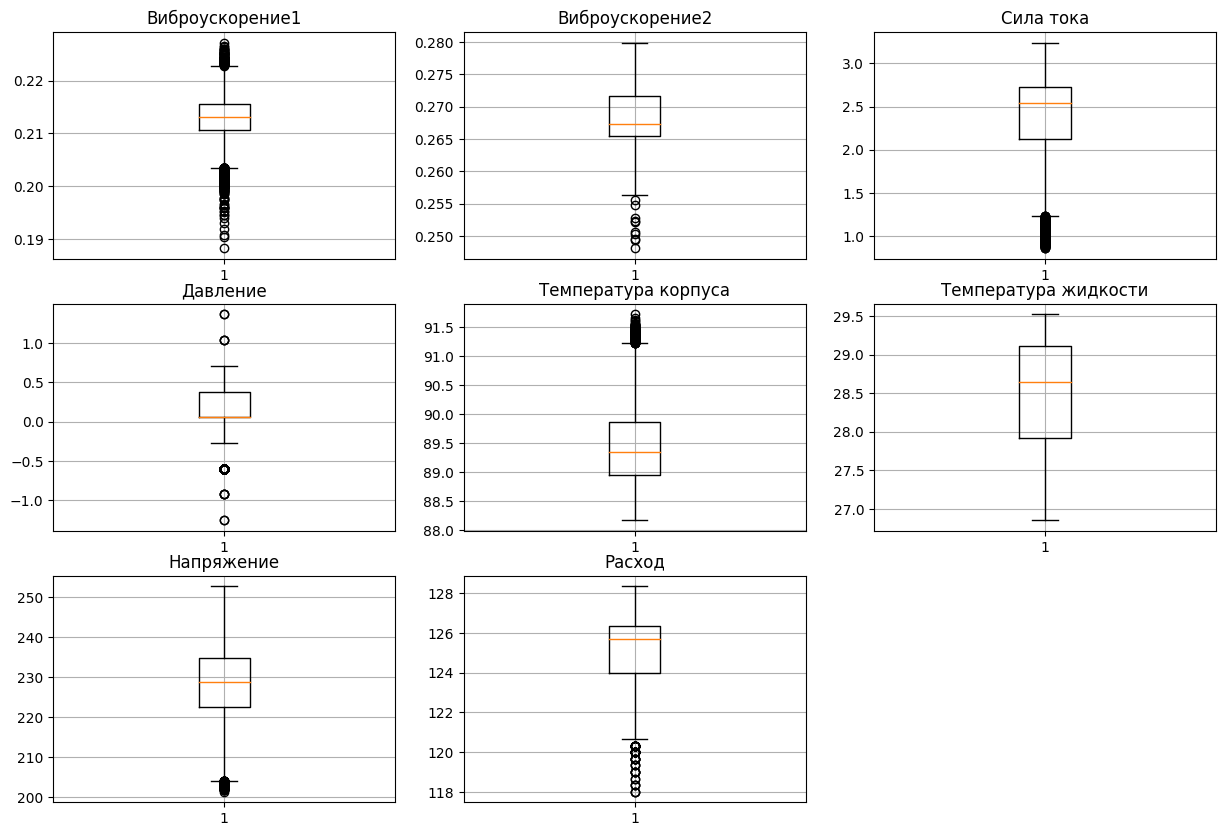

In [42]:
plt.figure(figsize = (15,10))
for ind, col in enumerate(anomaly_free_data):
    plt.subplot(3,3,ind+1)
    plt.boxplot(anomaly_free_data[col])
    plt.title(col)
    plt.grid()

По диаграммам ящиков с усами и гистограммам распределения заметны выбросы по всем признакам.

<a id="2.2.4.3"></a>
### 3.5.2 Графики сигналов (за весь период)
Для поиска трендов и других паттернов в данных, посмотрим как ведут себя значения сигналов на всем имеющемся периоде

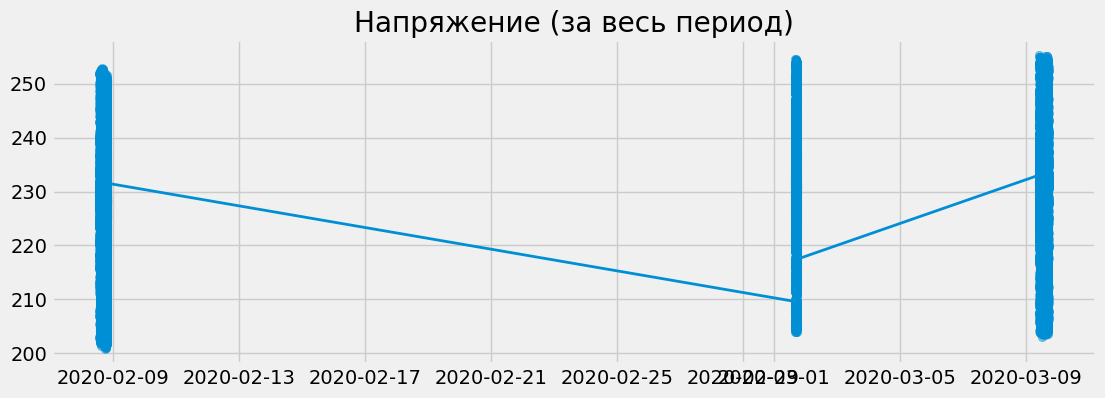

In [43]:
alldata = pd.concat(dfs)
alldata = alldata.sort_index()

fast_plot(alldata['Напряжение'], title='Напряжение (за весь период)')

Видно три периода в данных.

Из-за больших перерывов между экспериментами, на таких графиках трудно разглядеть что-то ценное, можно построить графики для отдельных дней.

Также мы можем посчитать количество экспериментов, которые были выполнены за каждый день.

In [44]:
# Количество экспериментов в каждый день
display(Markdown("__Количество экспериментов в каждый день__"))
display(summary_table['start_time'].dt.date.value_counts().sort_index())
alldata = pd.concat(dfs)
alldata = alldata.sort_index()

__Количество экспериментов в каждый день__

start_time
2020-02-08    11
2020-03-01     4
2020-03-09    20
Name: count, dtype: int64

Построим графики дял каждого из дней по отдельности

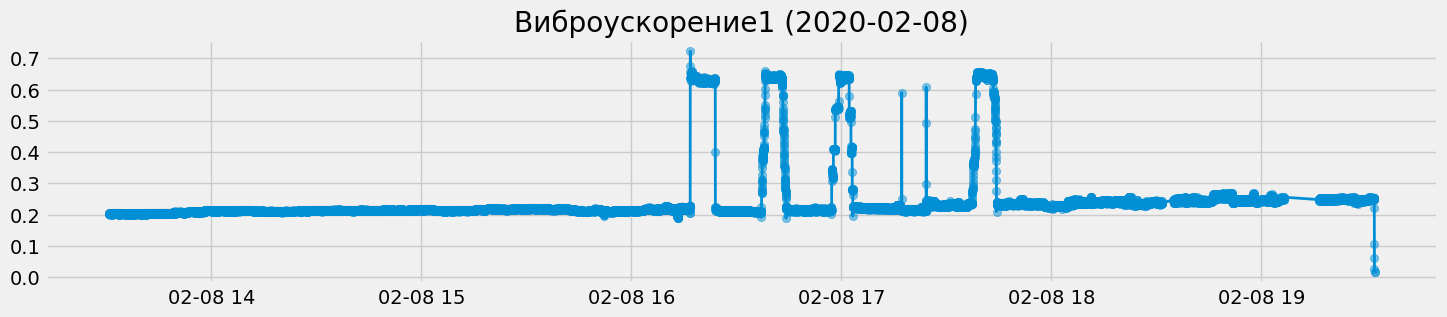

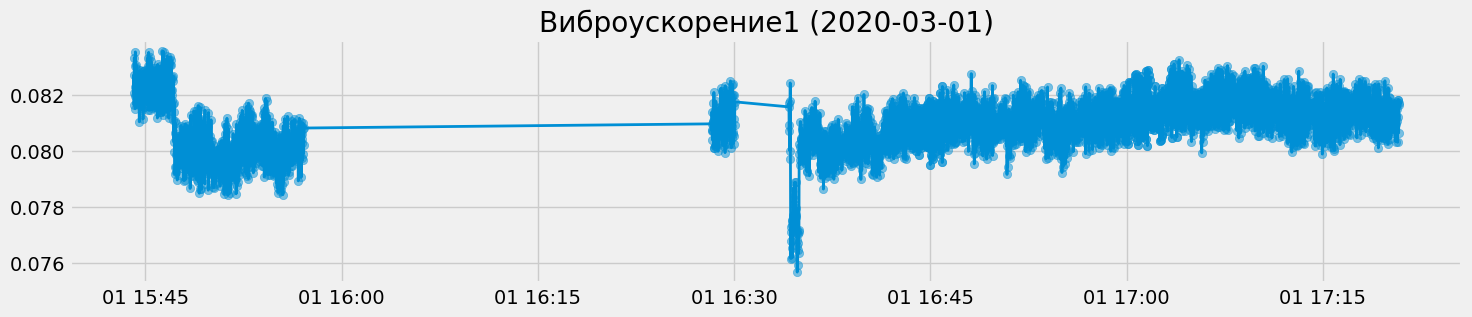

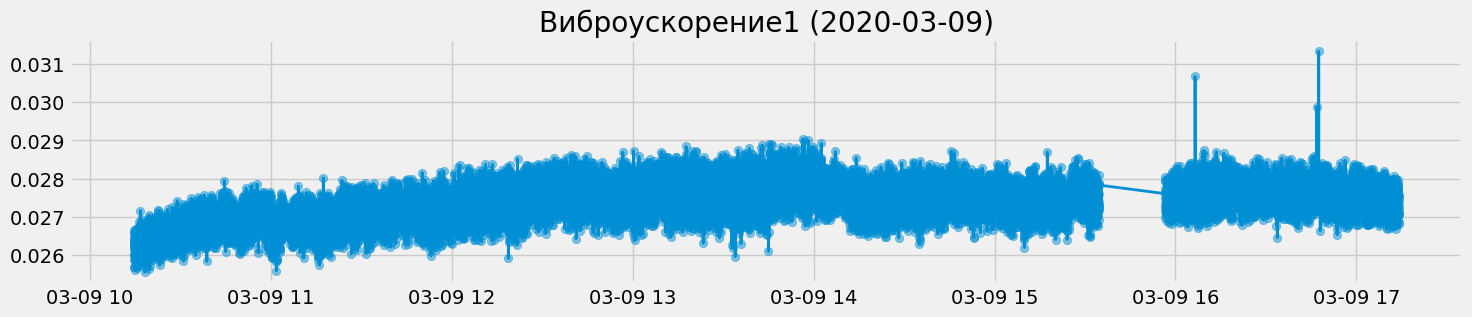

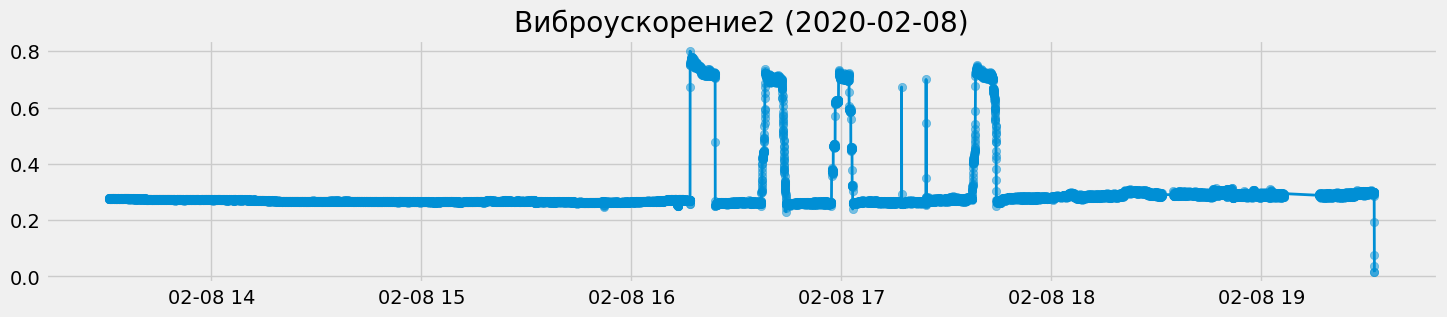

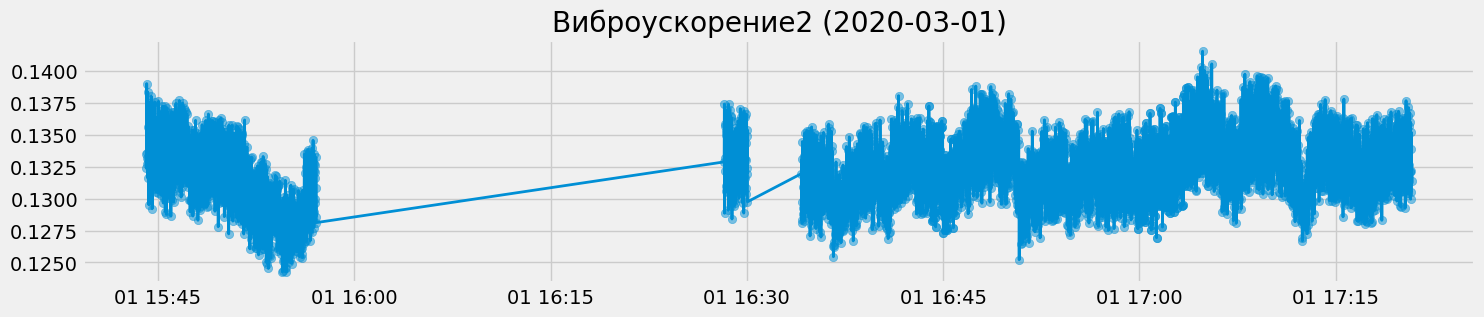

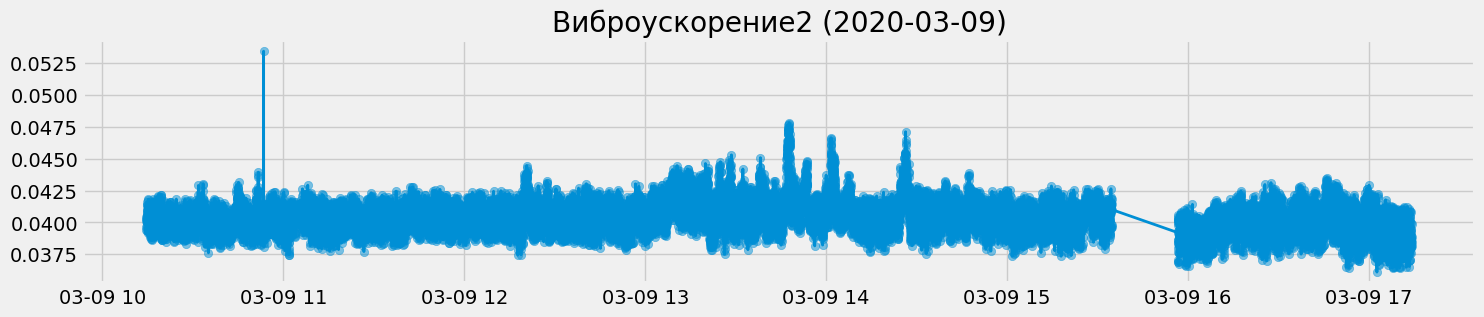

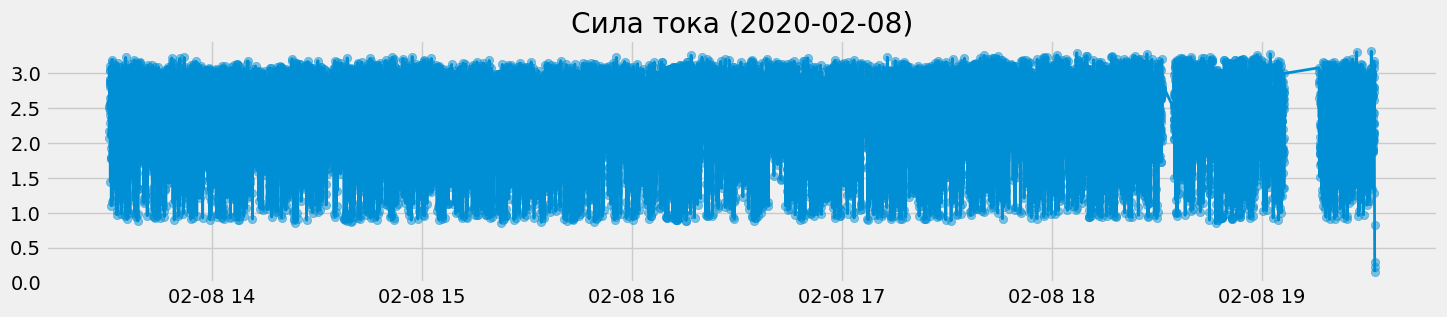

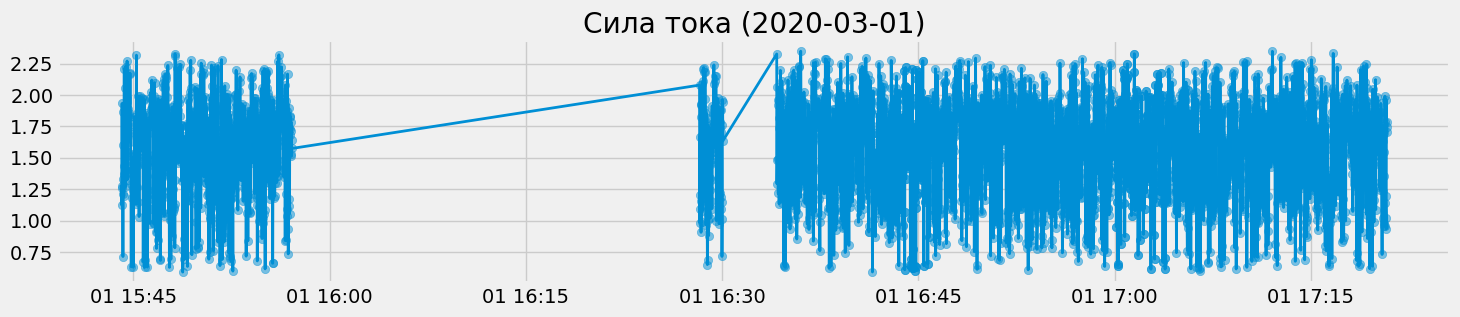

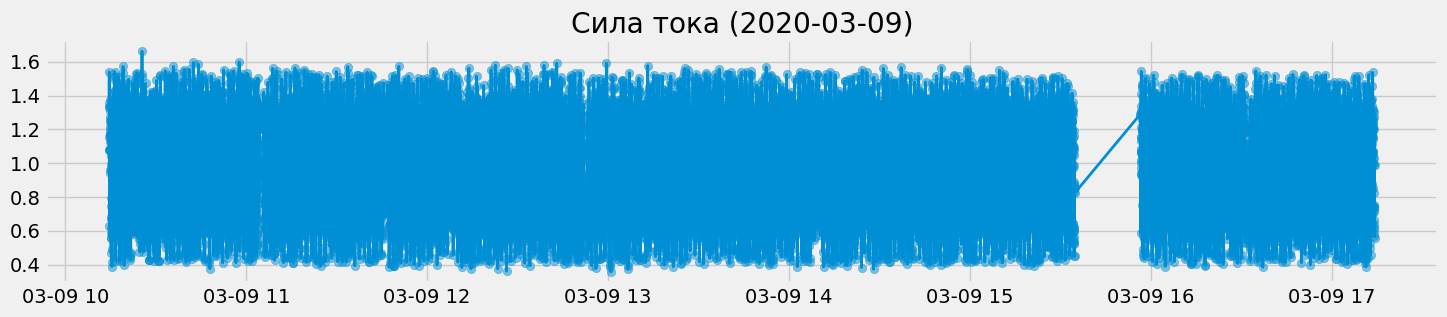

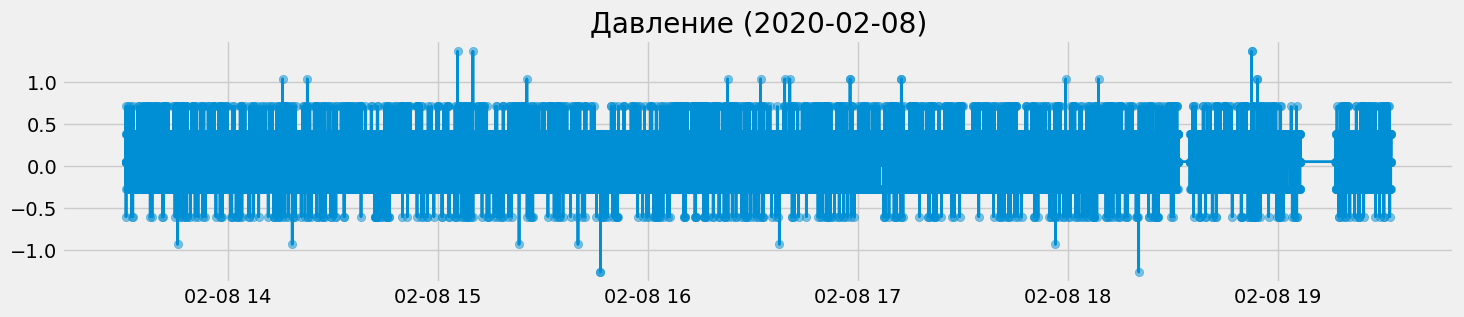

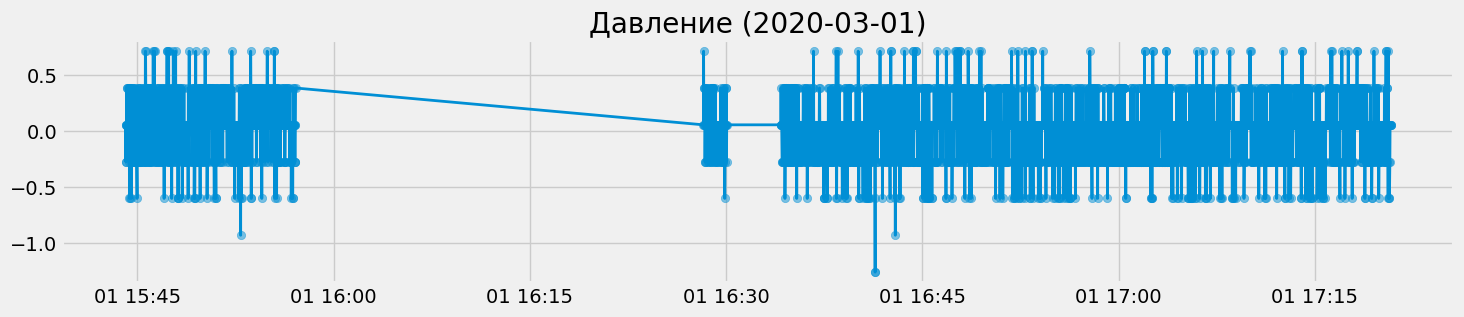

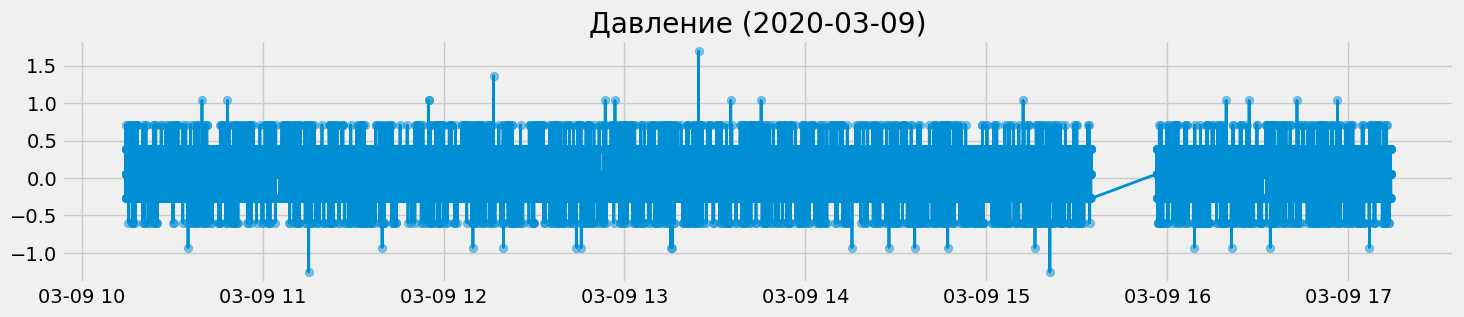

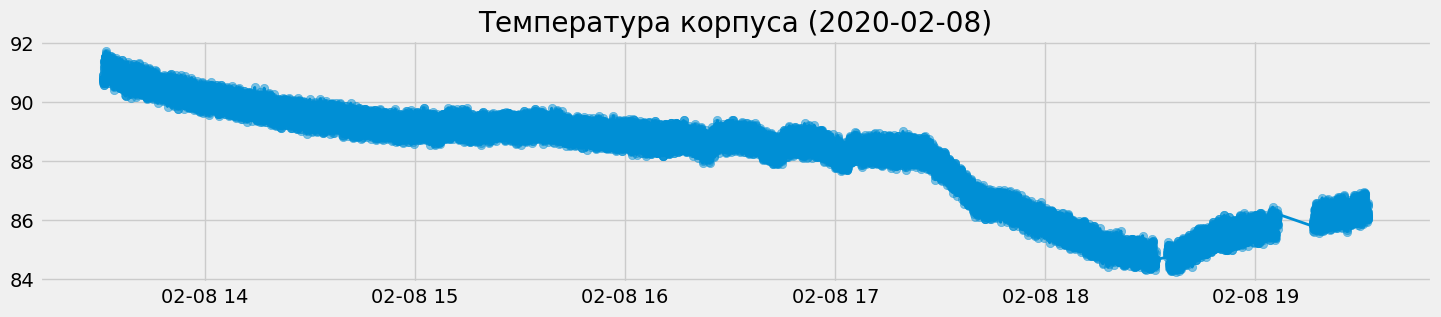

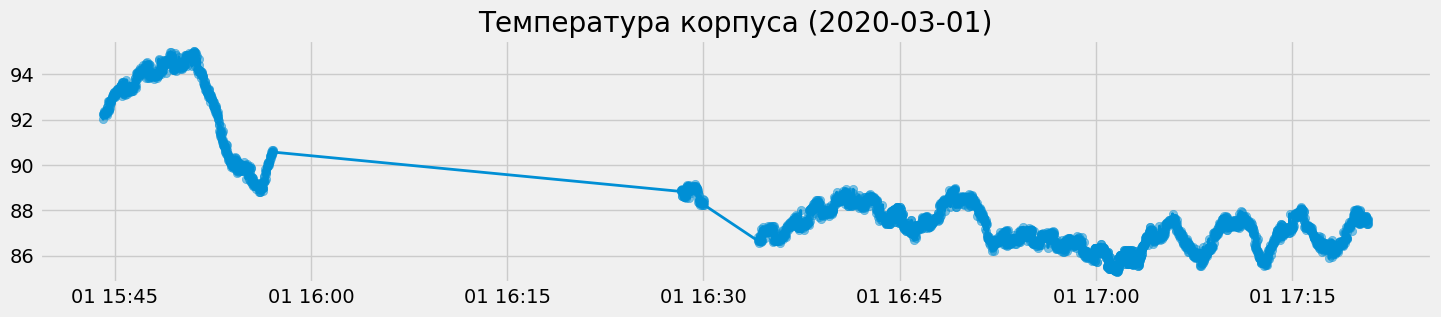

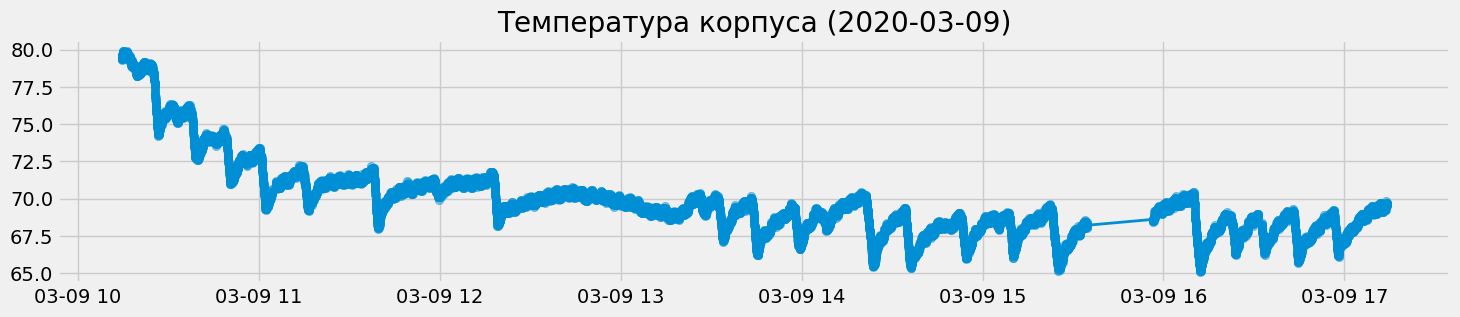

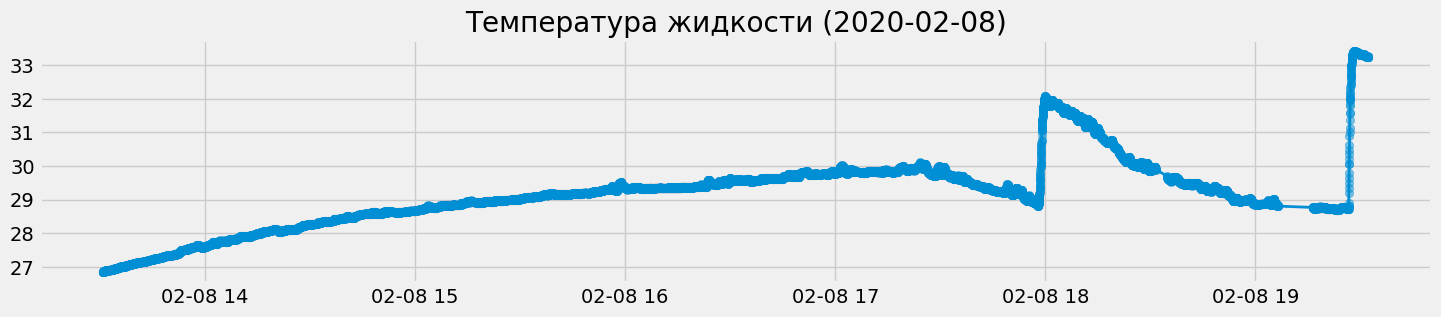

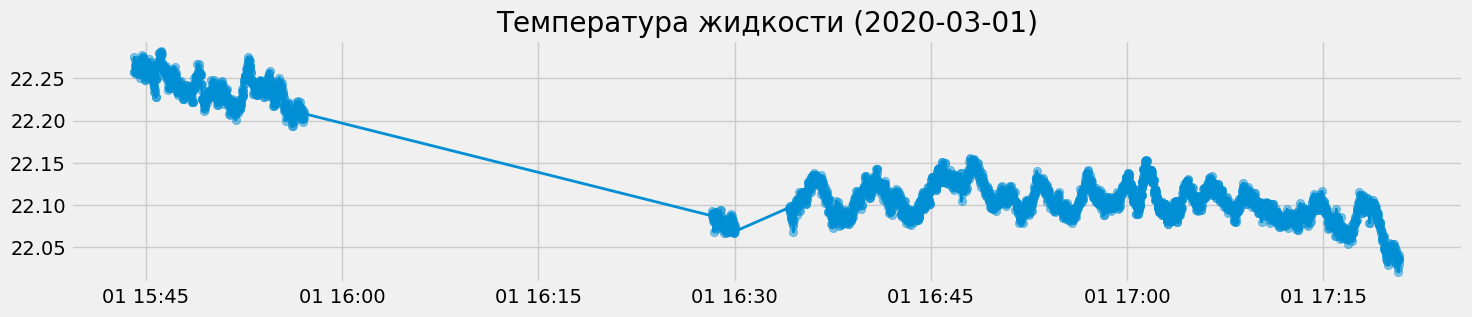

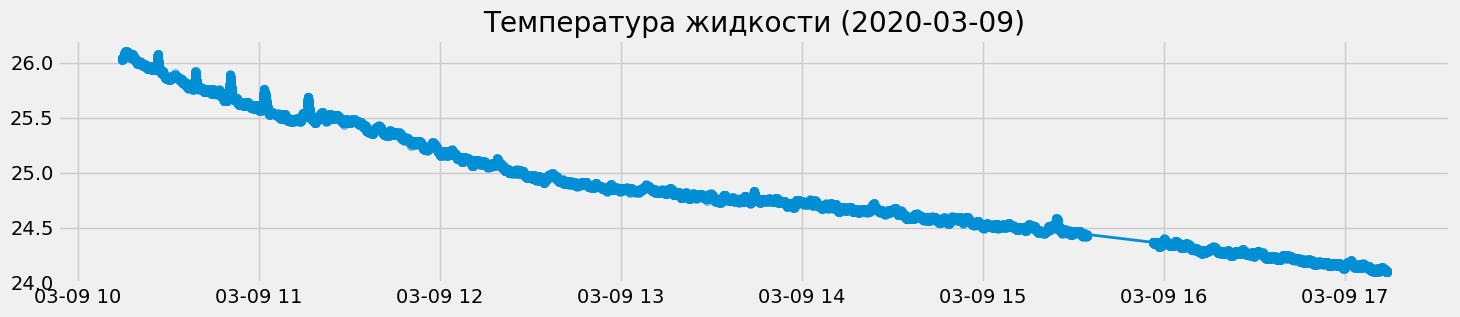

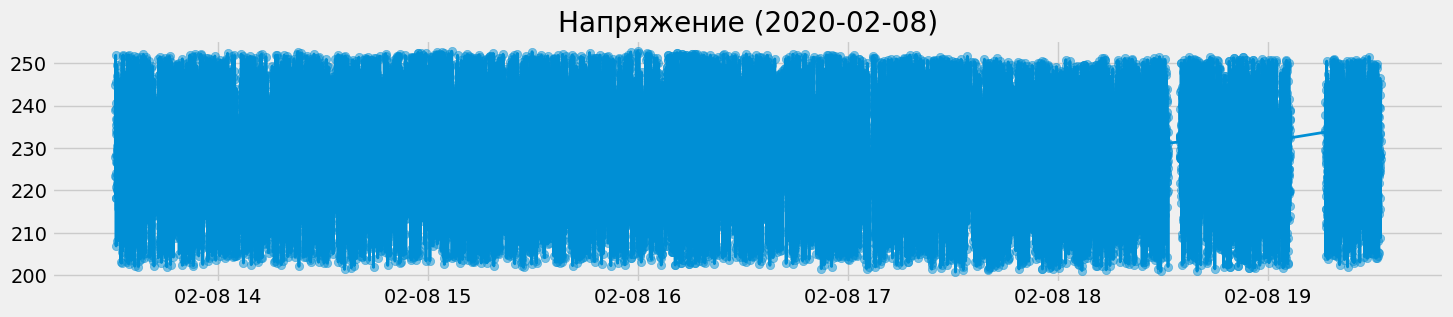

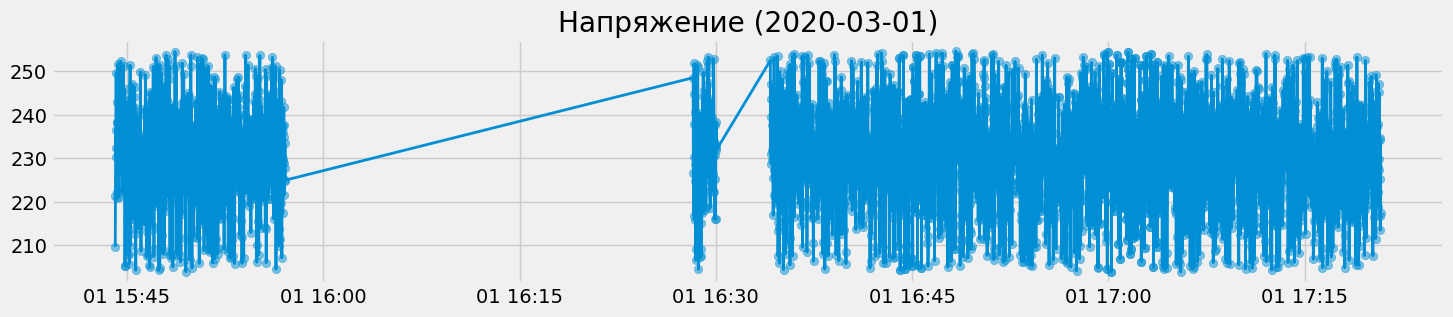

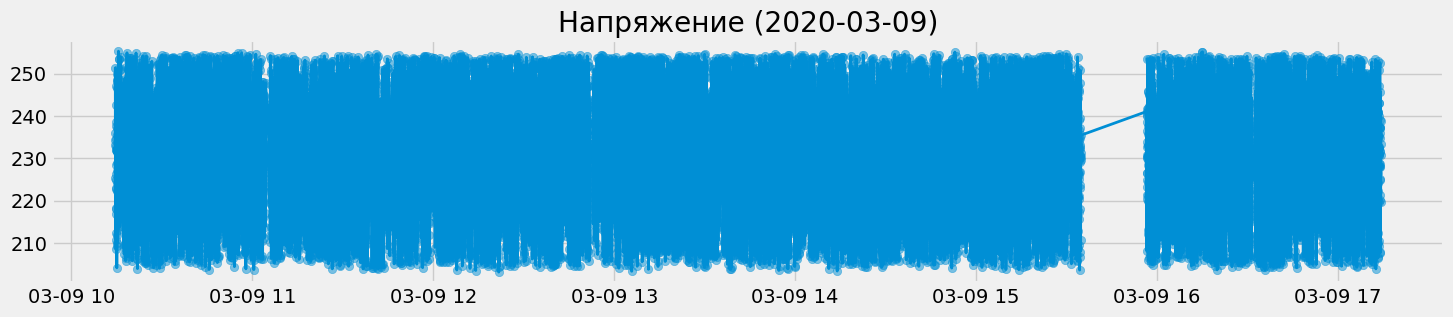

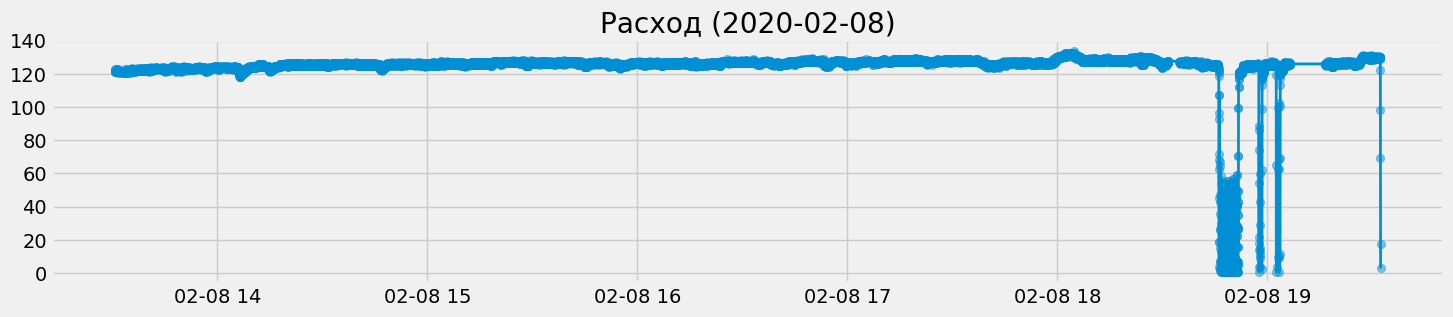

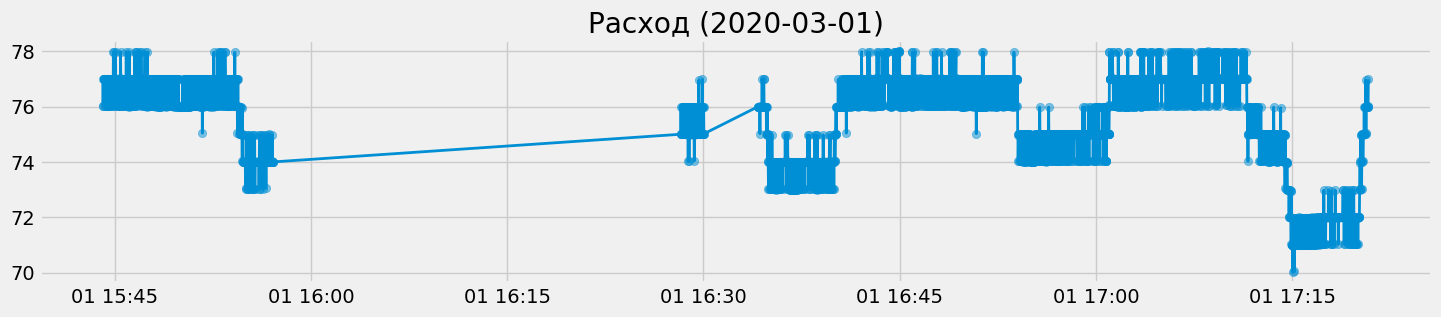

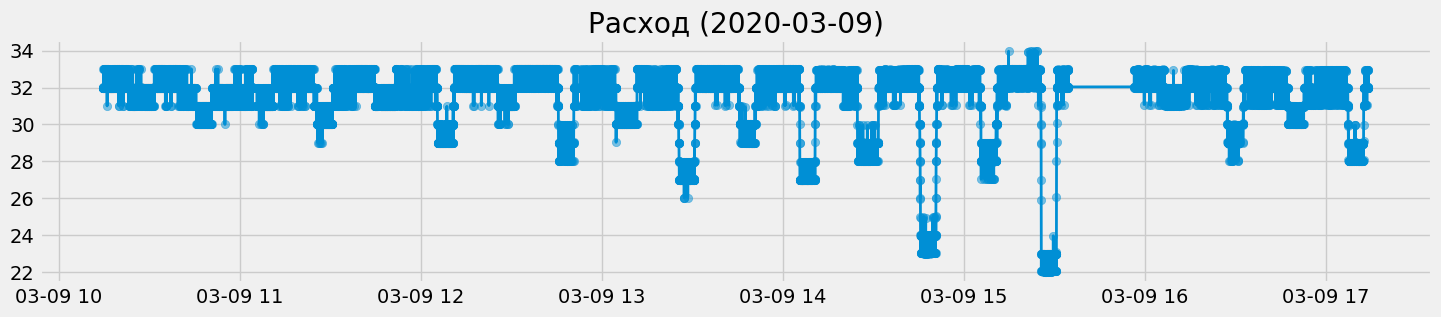

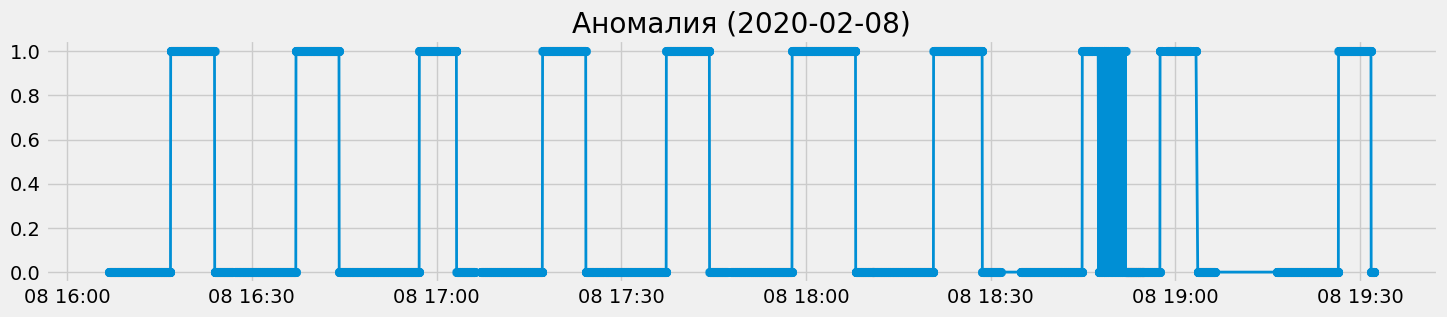

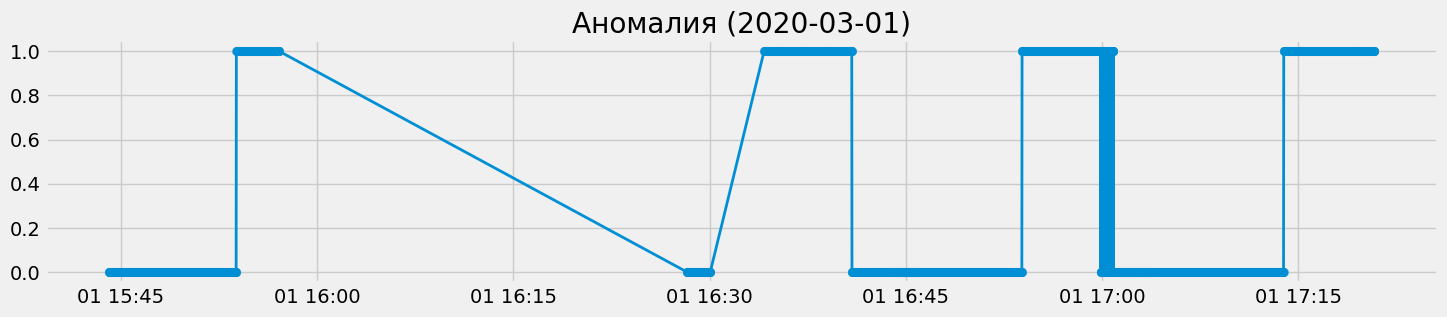

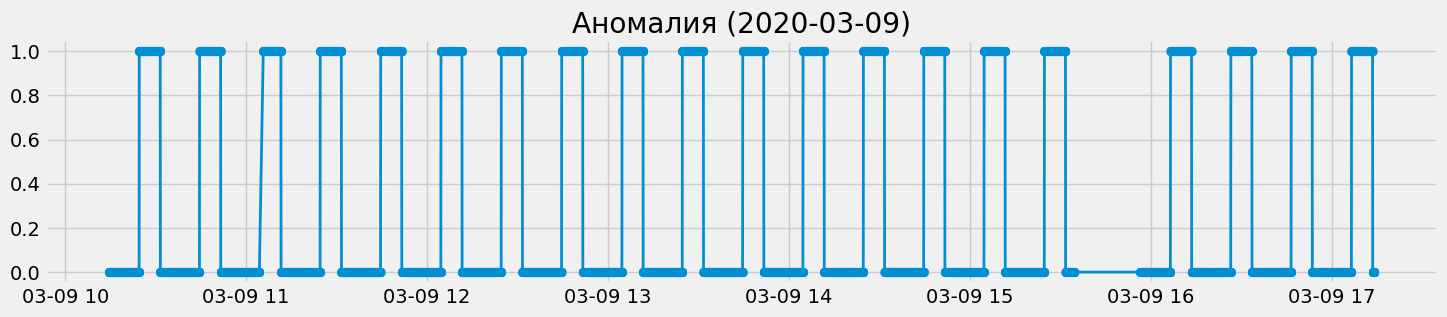

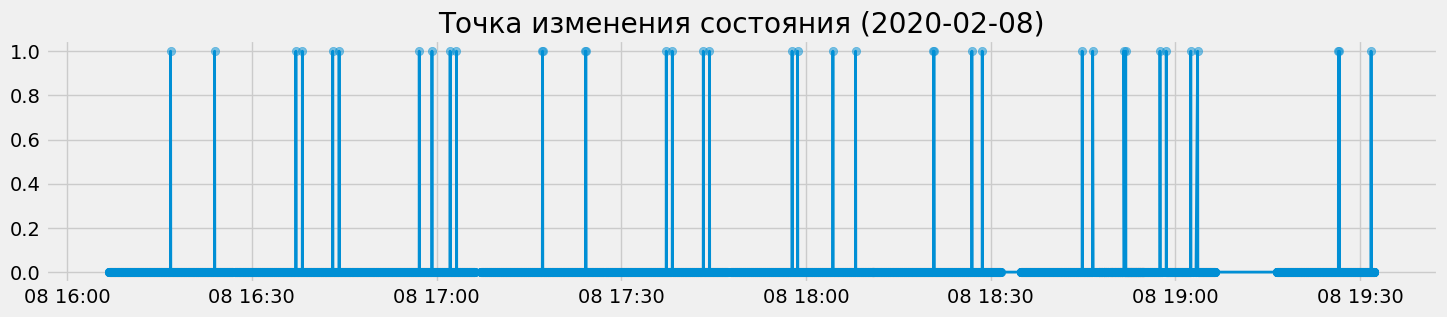

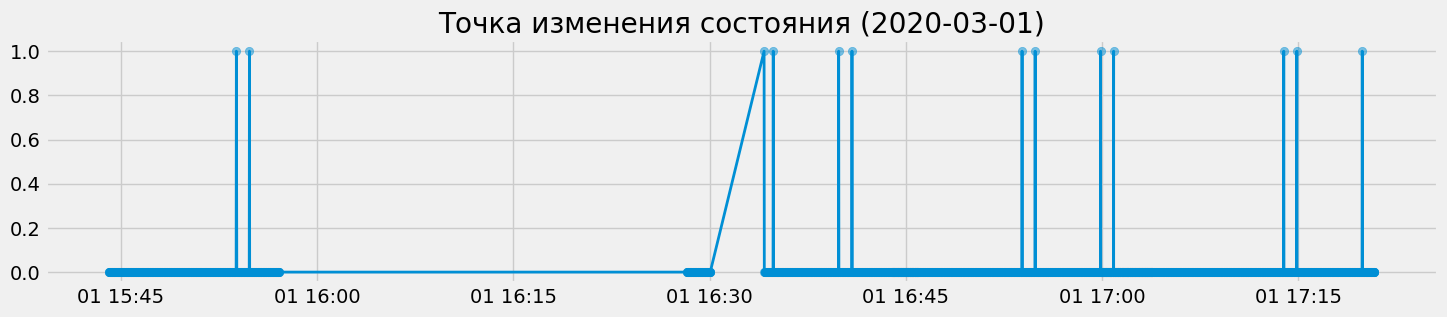

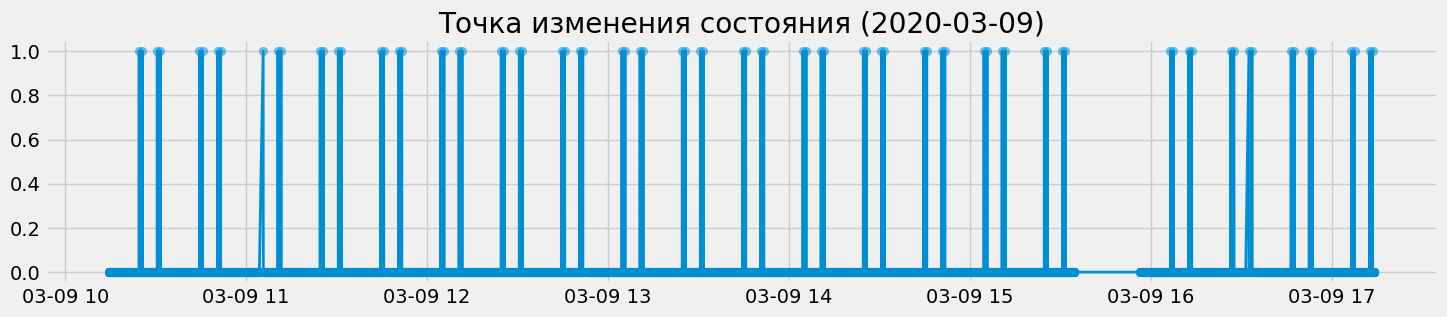

In [45]:
for column in alldata.columns:
    fast_plot(alldata[column]['2020-02-08'], title=column + ' (2020-02-08)', figsize=(16, 3))
    plt.show()
    fast_plot(alldata[column]['2020-03-01'], title=column + ' (2020-03-01)', figsize=(16, 3))
    plt.show()
    fast_plot(alldata[column]['2020-03-09'], title=column + ' (2020-03-09)', figsize=(16, 3))
    plt.show()
    print('\n\n')

Построим гистограммы распределения для всех дней (полный набор данных по экспериментам)

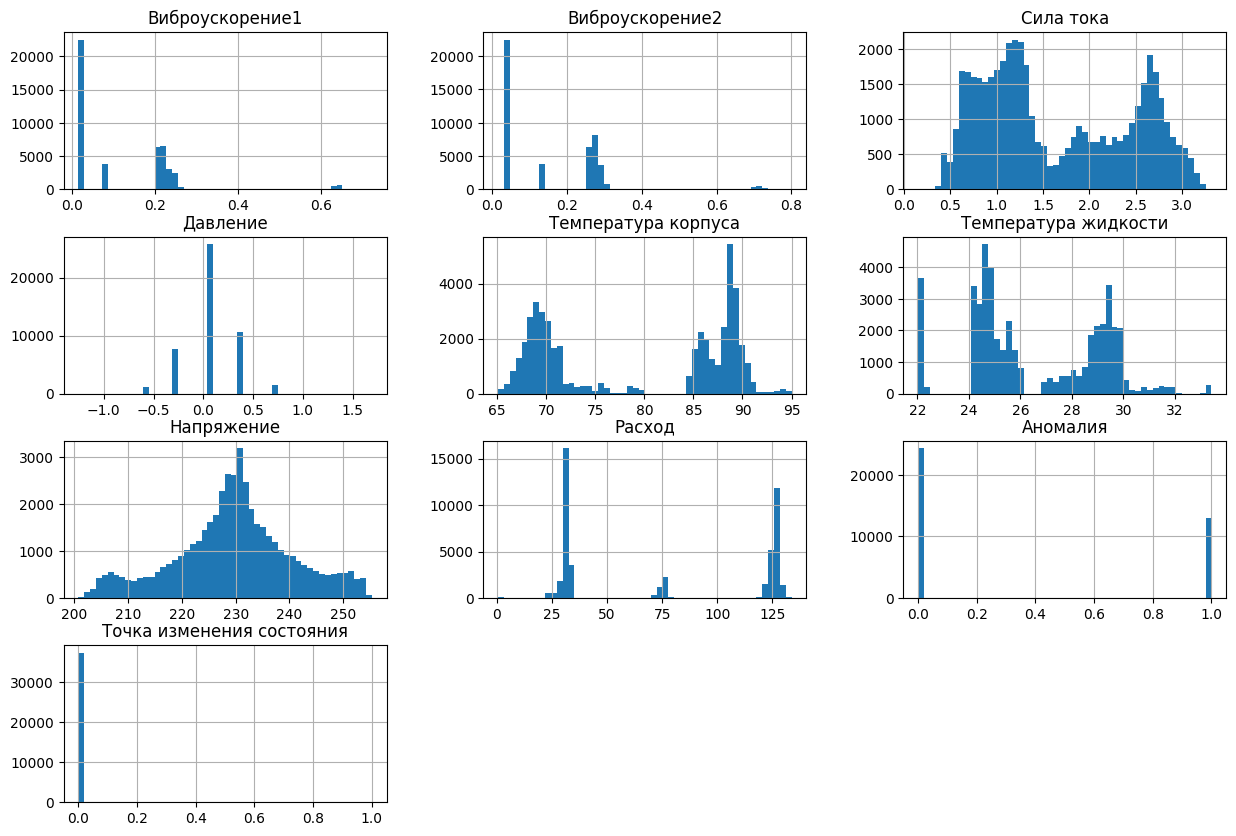

In [46]:
alldata.hist(figsize=(15,10), bins = 50);

Построим диаграммы ящиков с усами для полного набора данных

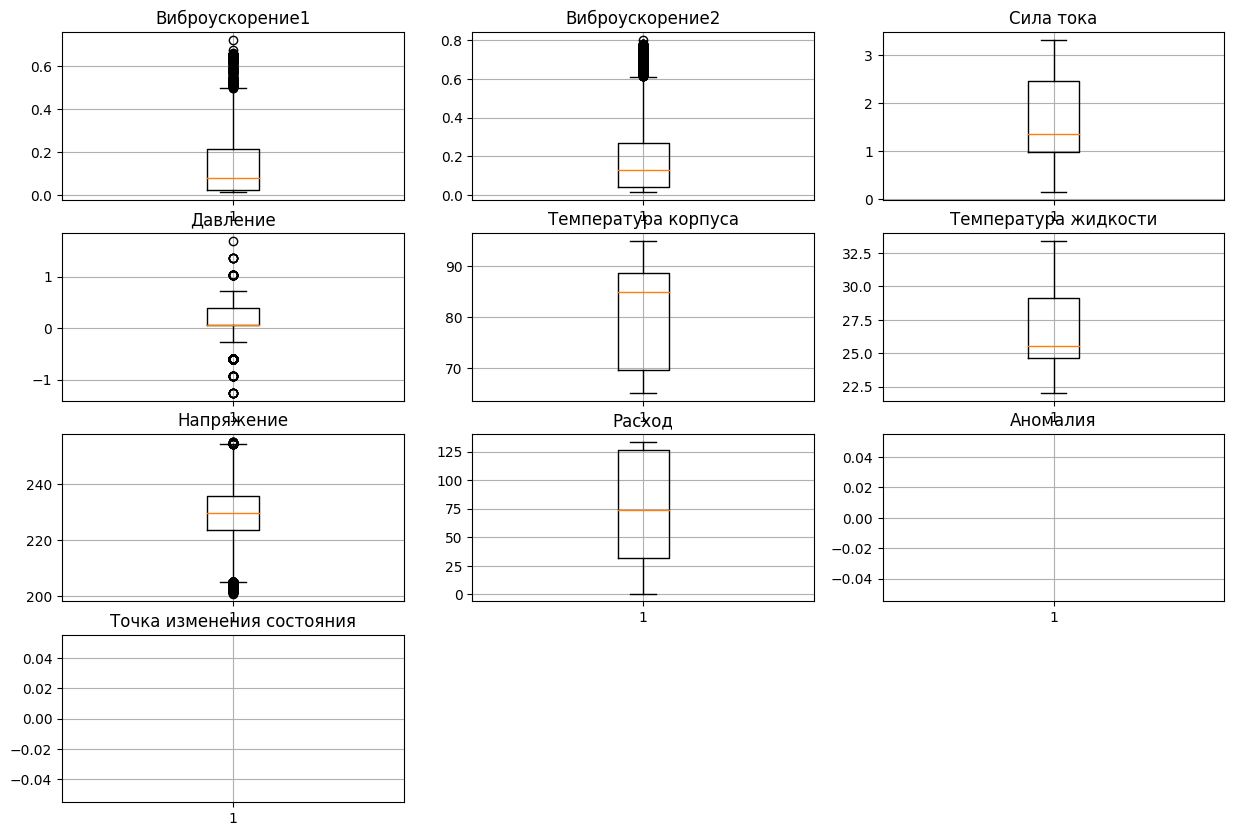

In [47]:
plt.figure(figsize = (15,10))
for ind, col in enumerate(alldata):
    plt.subplot(4,3,ind+1)
    plt.boxplot(alldata[col])
    plt.title(col)
    plt.grid()

<a id="2.2.4.4"></a>
### 3.5.3 Графики (данные c аномалиями)

Посмотрим отдельно на данные с наличием аномалий.

Проанализируем как сглаживание сигнала может уменьшить шум, для этого построим графики сигналов и их сглаженные значения за 10 секунд

Рассмотрим несколько экспериментов

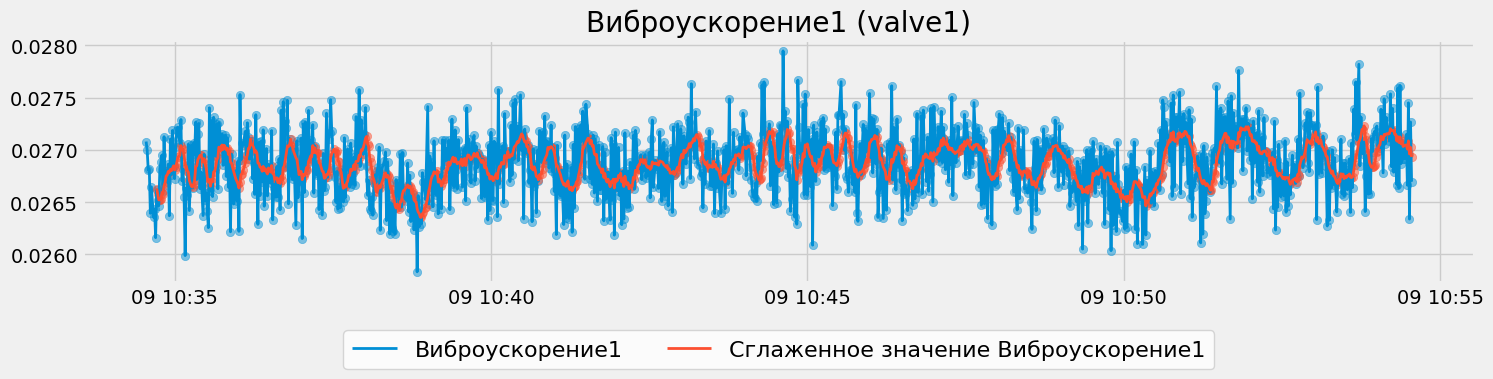

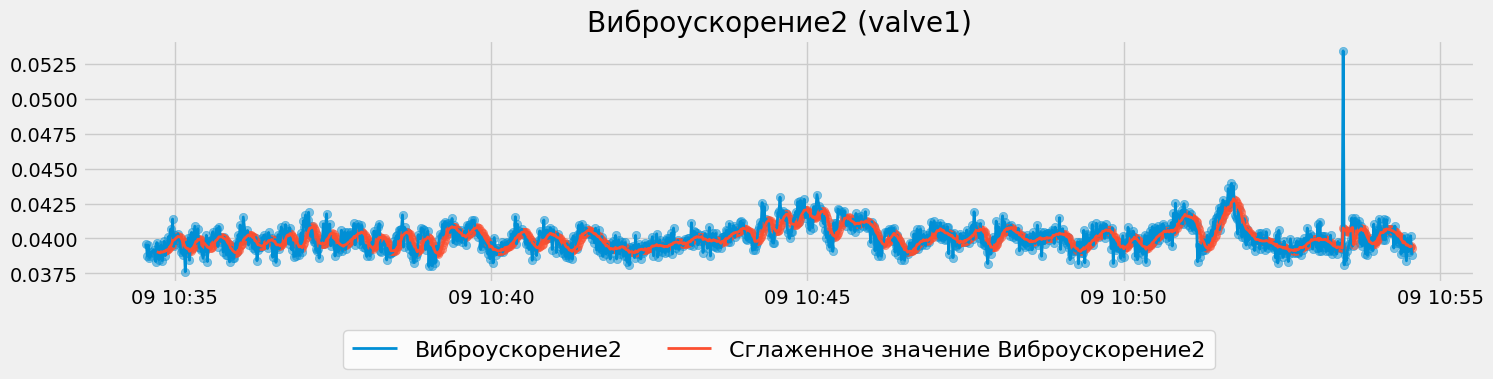

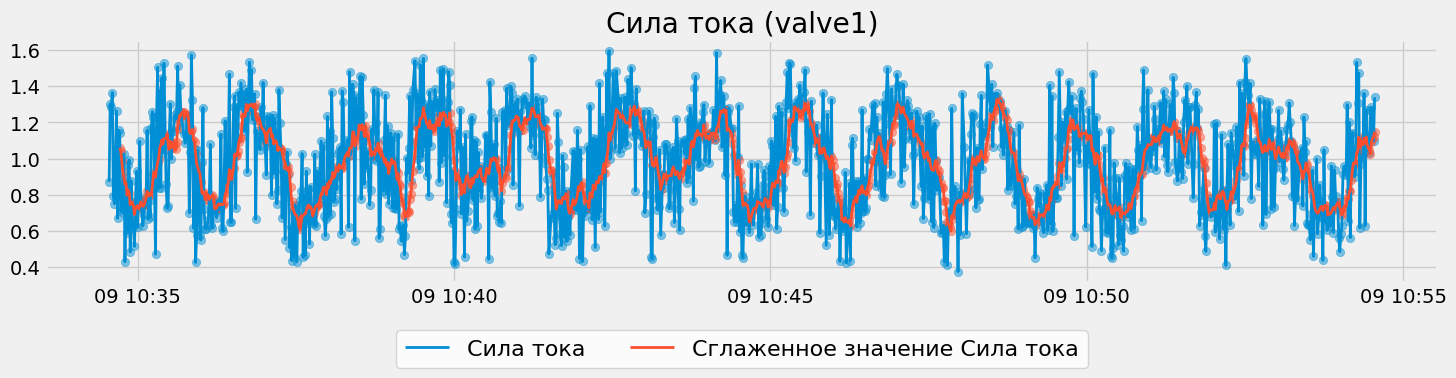

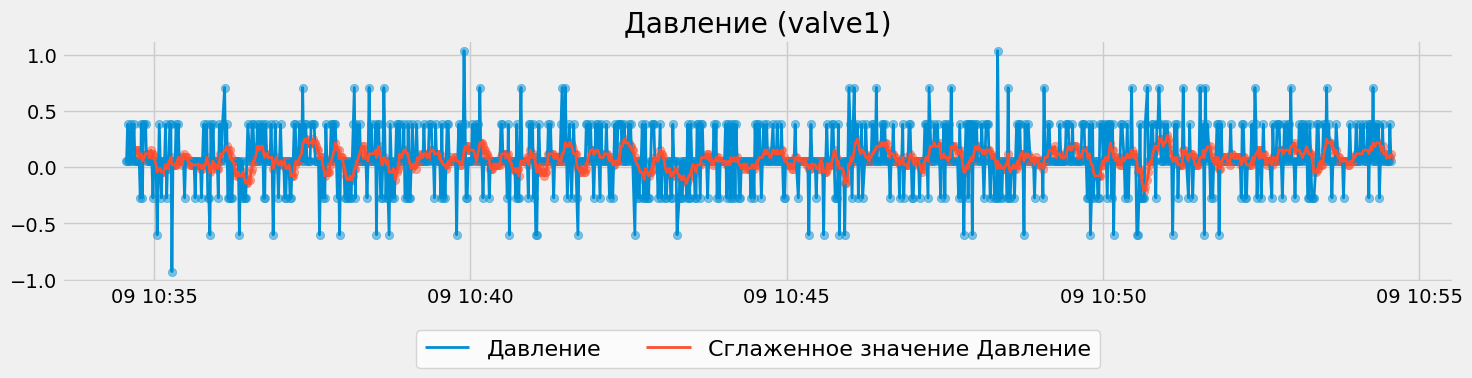

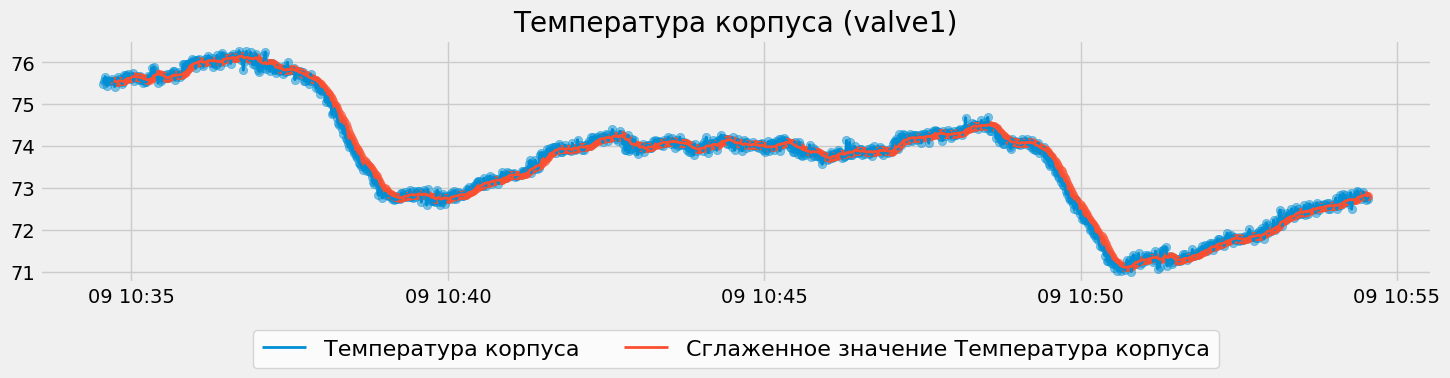

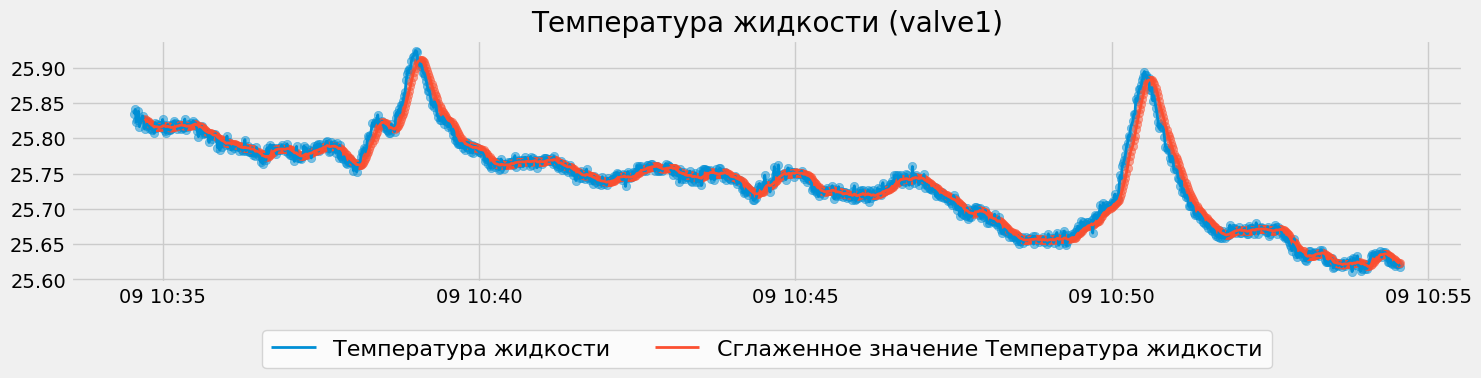

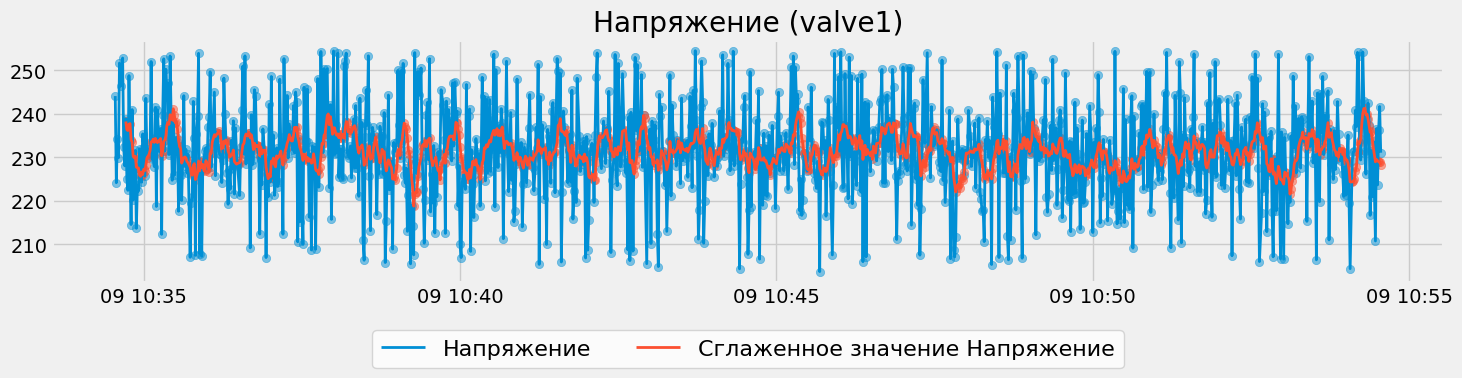

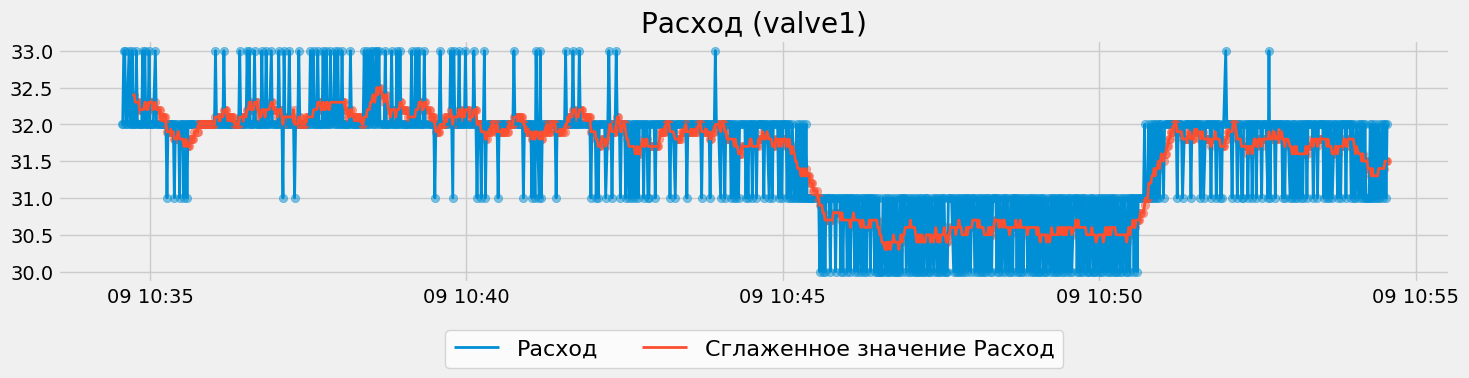

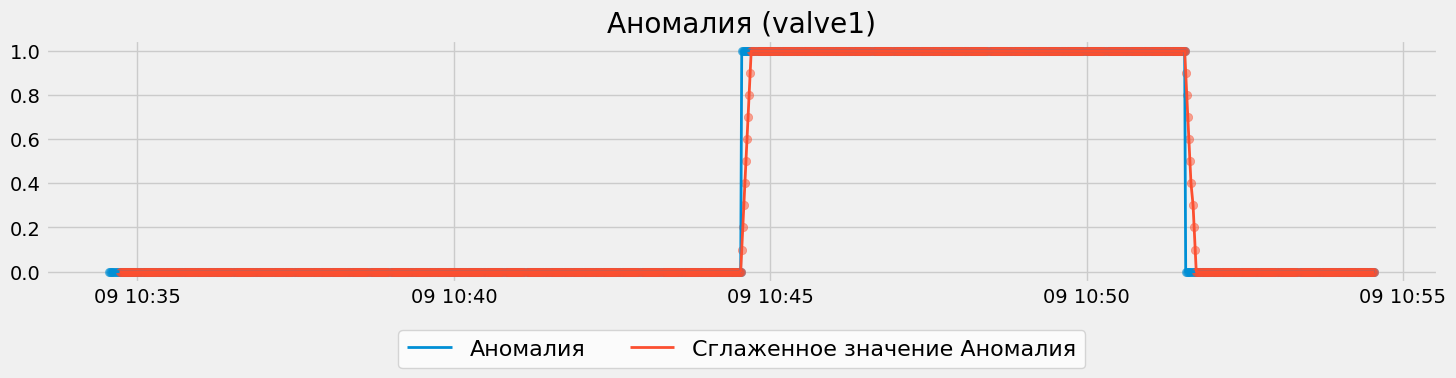

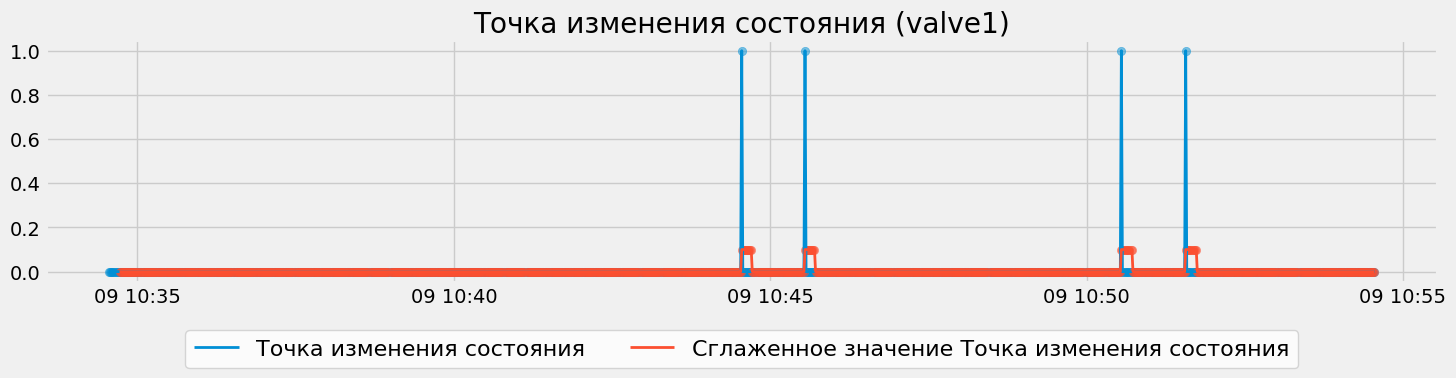

In [48]:
for column in valve1_data[1].columns:
    fast_plot(valve1_data[1][column], title=column + ' (valve1)', figsize=(16, 3), label=column)
    fast_plot(valve1_data[1][column], rolling=10, new_figure=False, label=f'Сглаженное значение {column}')
    fast_legend()

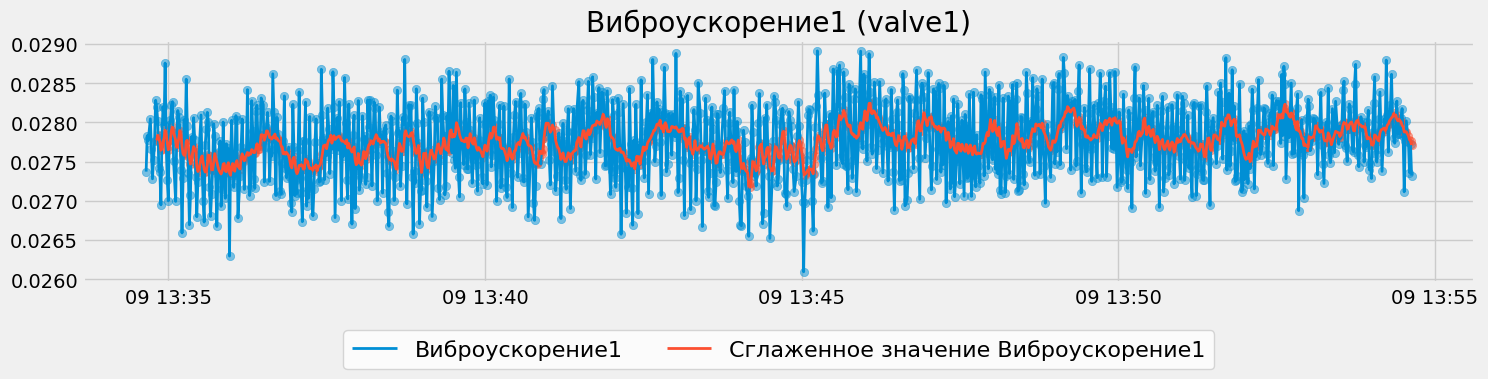

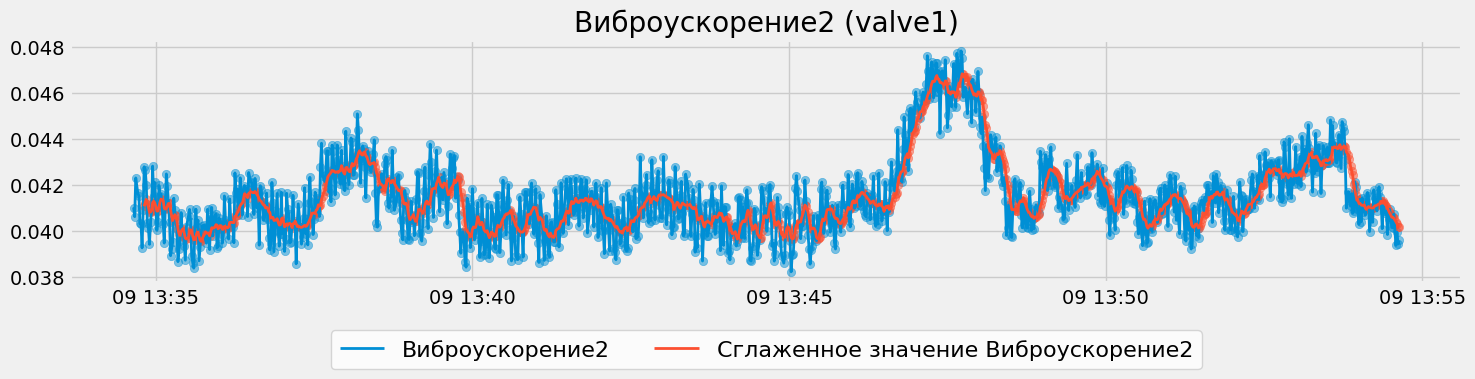

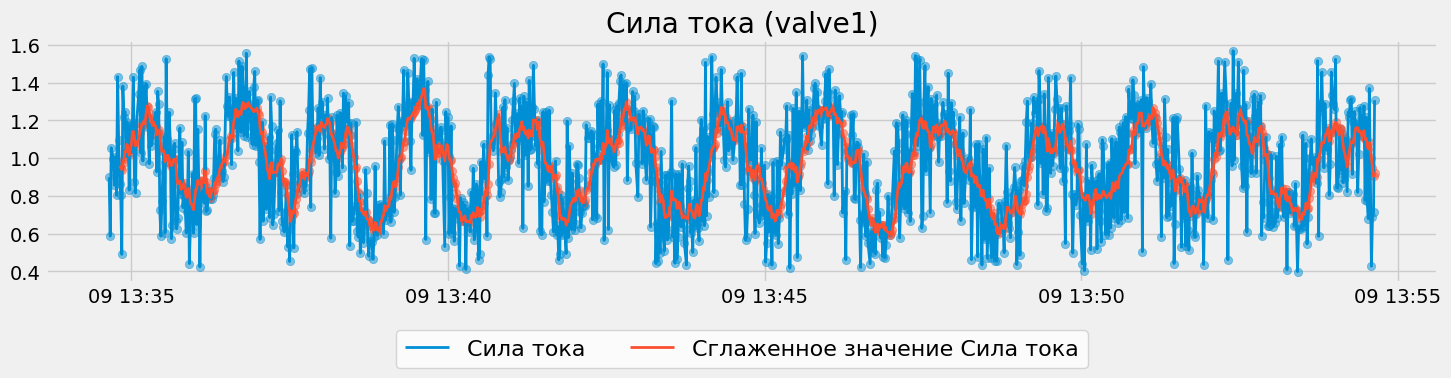

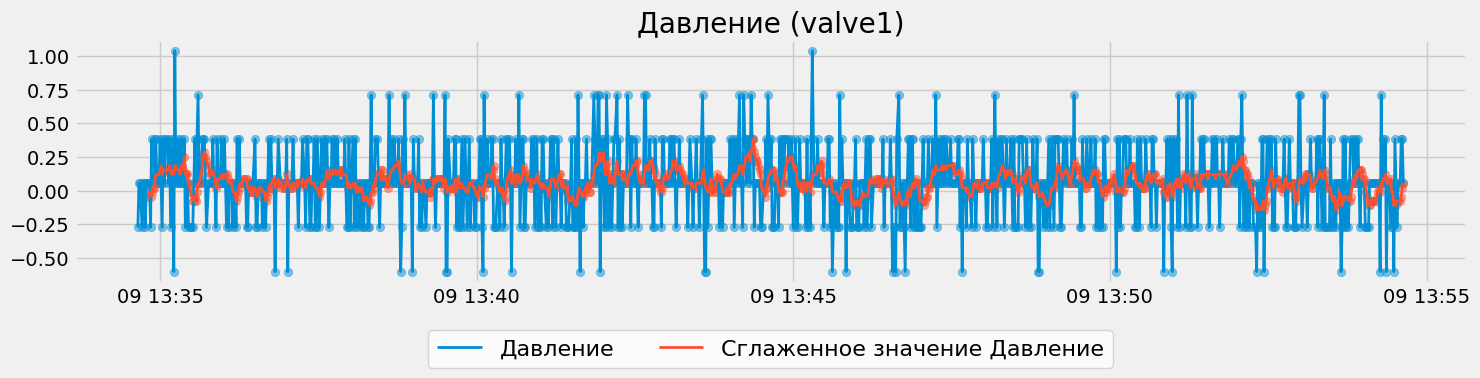

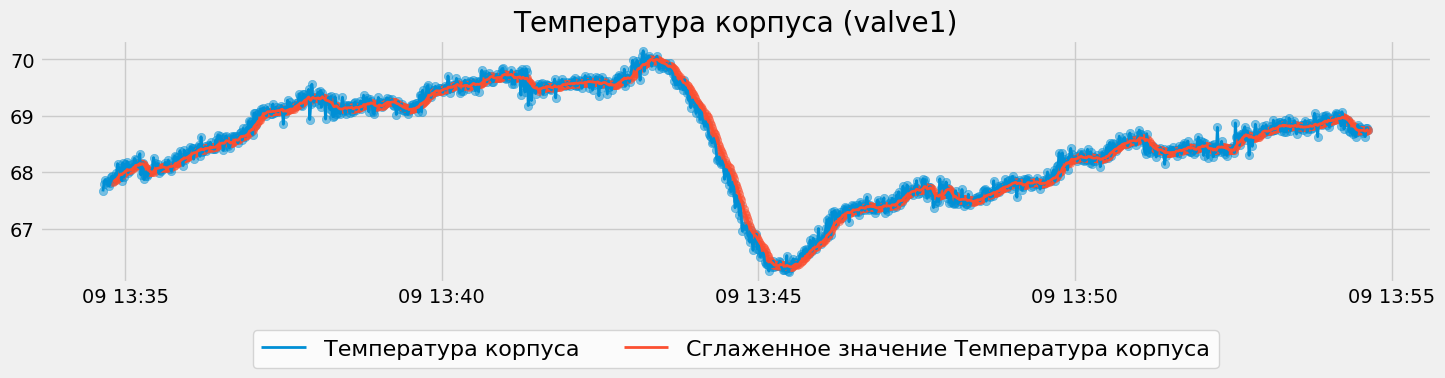

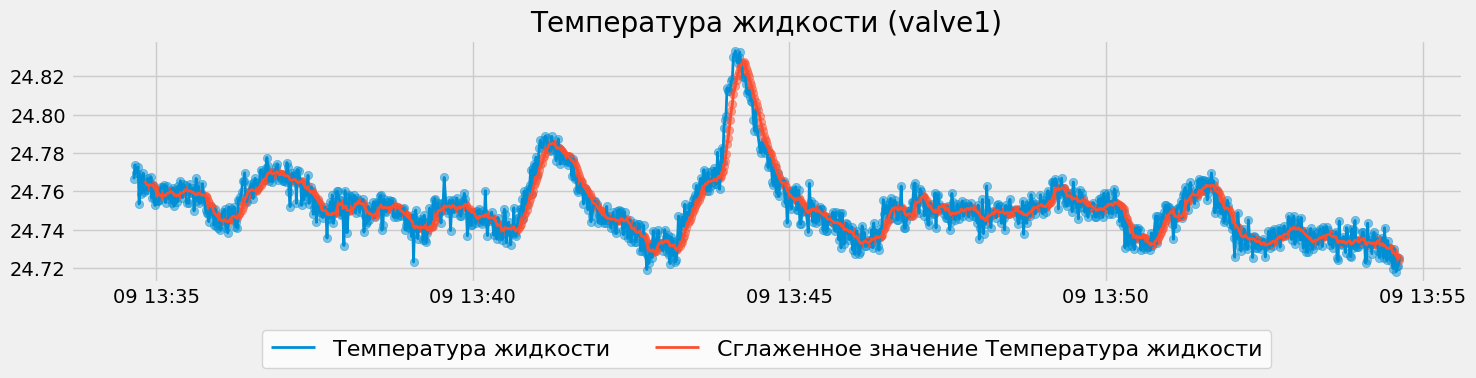

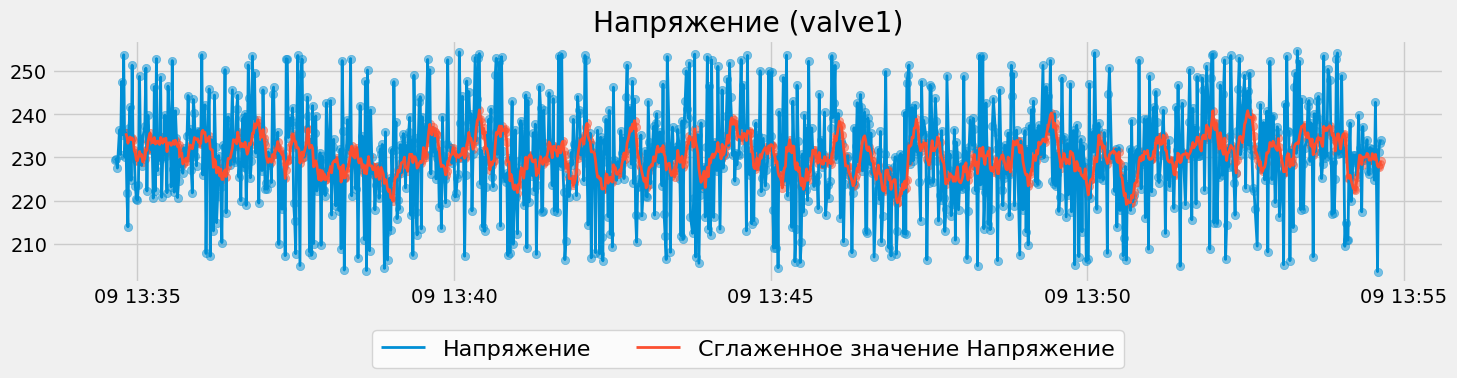

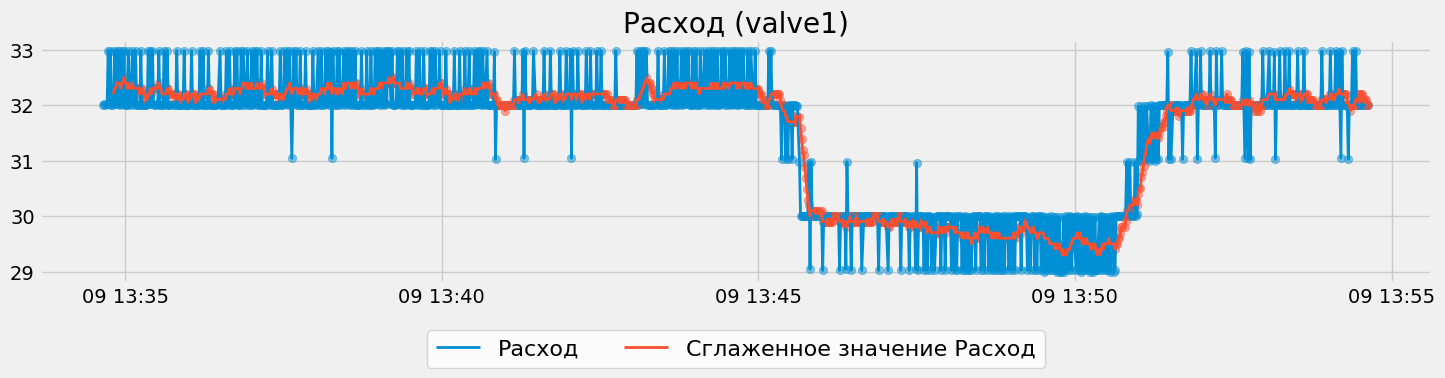

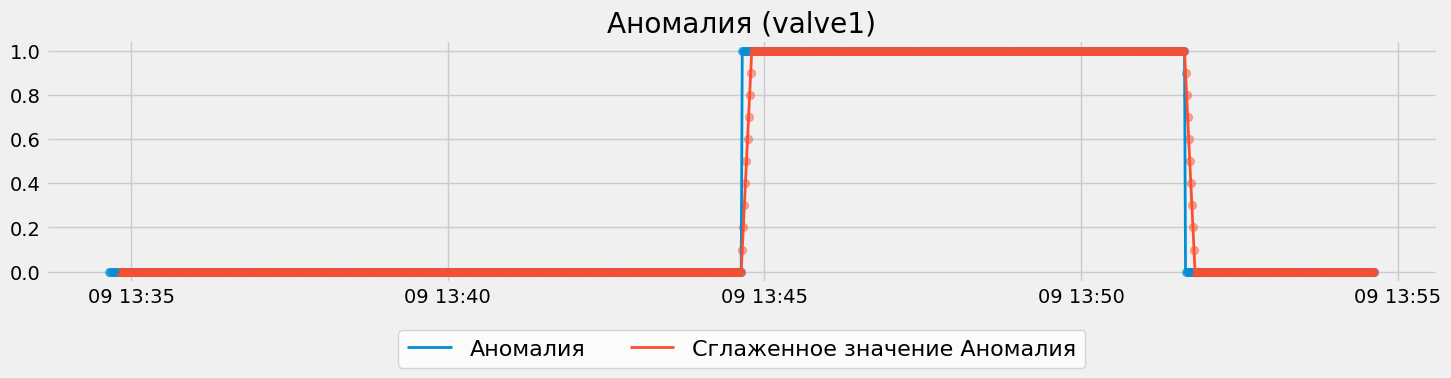

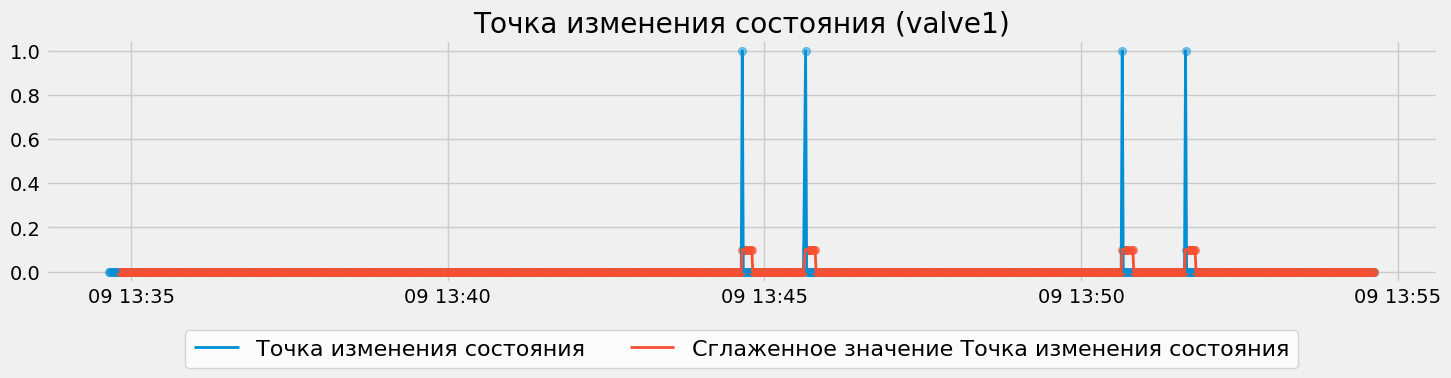

In [49]:
for column in valve1_data[2].columns:
    fast_plot(valve1_data[2][column], title=column + ' (valve1)', figsize=(16, 3), label=column)
    fast_plot(valve1_data[2][column], rolling=10, new_figure=False, label=f'Сглаженное значение {column}')
    fast_legend()

Для некоторых признаков, имеющих высокий разброс значений и выбросы, можно использовать сглаживание во время генерации дополнительных признаков и подготовки данных

<a id="2.2.6"></a>
### 3.5.4 Попарные корреляции
Для поиска взаимосвязей между признаками зачастую может быть использована информация о попарной корреляции

__Данные без аномалий:__

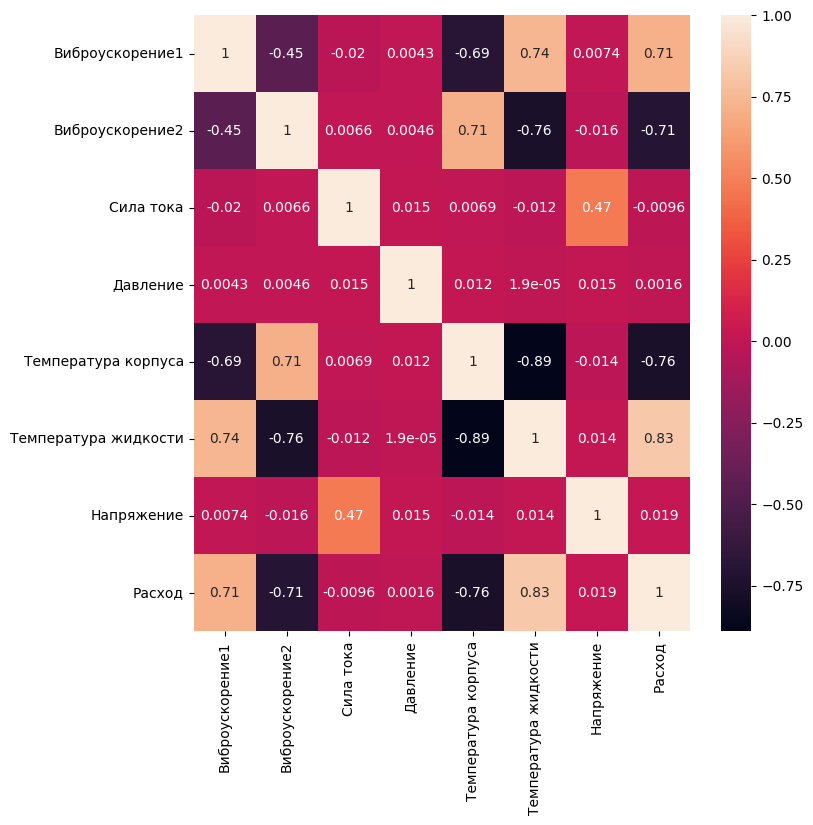

In [50]:
plt.figure(figsize=(8, 8))
display(Markdown('__Данные без аномалий:__'))
sns.heatmap(anomaly_free_data.corr(), annot = True, fmt='.2g');

__Данные в датасете "valve1" эксперимент №2:__

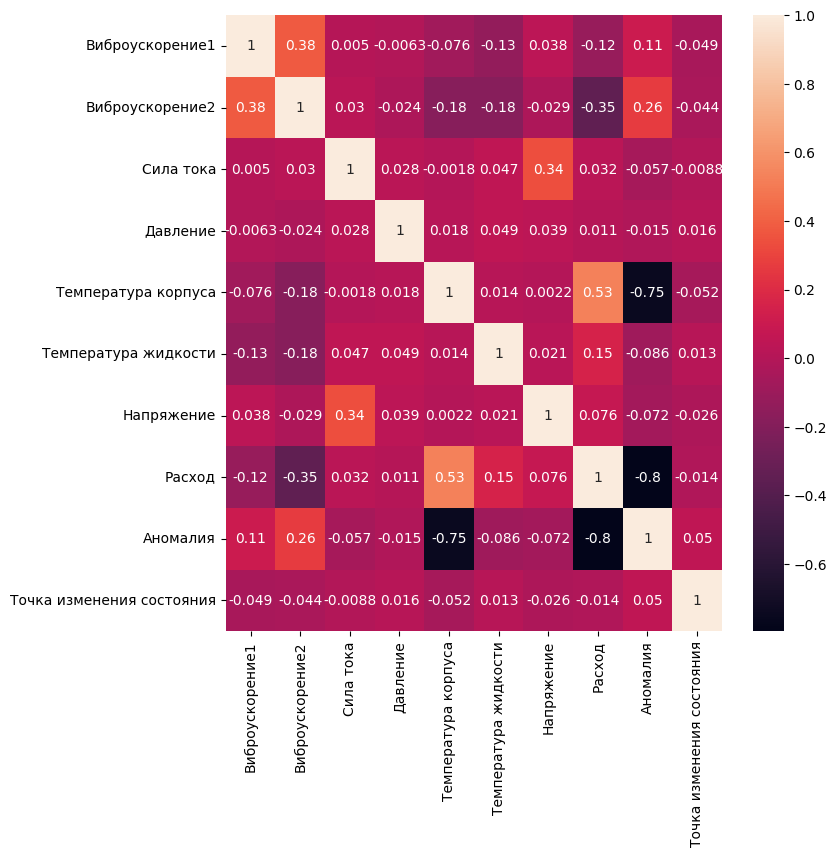

In [51]:
plt.figure(figsize=(8, 8))
display(Markdown('__Данные в датасете "valve1" эксперимент №2:__'))
sns.heatmap(valve1_data[2].corr(), annot = True, fmt='.2g');

__Данные в датасете "valve1" эксперимент №2:__

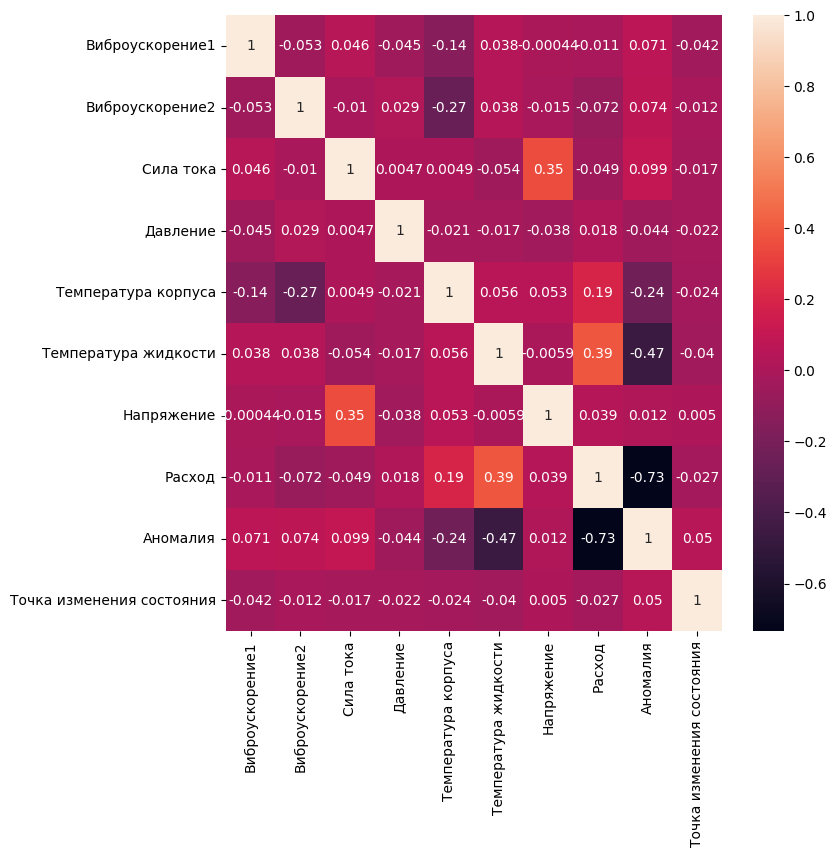

In [52]:
plt.figure(figsize=(8, 8))
display(Markdown('__Данные в датасете "valve1" эксперимент №2:__'))
sns.heatmap(valve2_data[2].corr(), annot = True, fmt='.2g');

__Данные за весь период:__

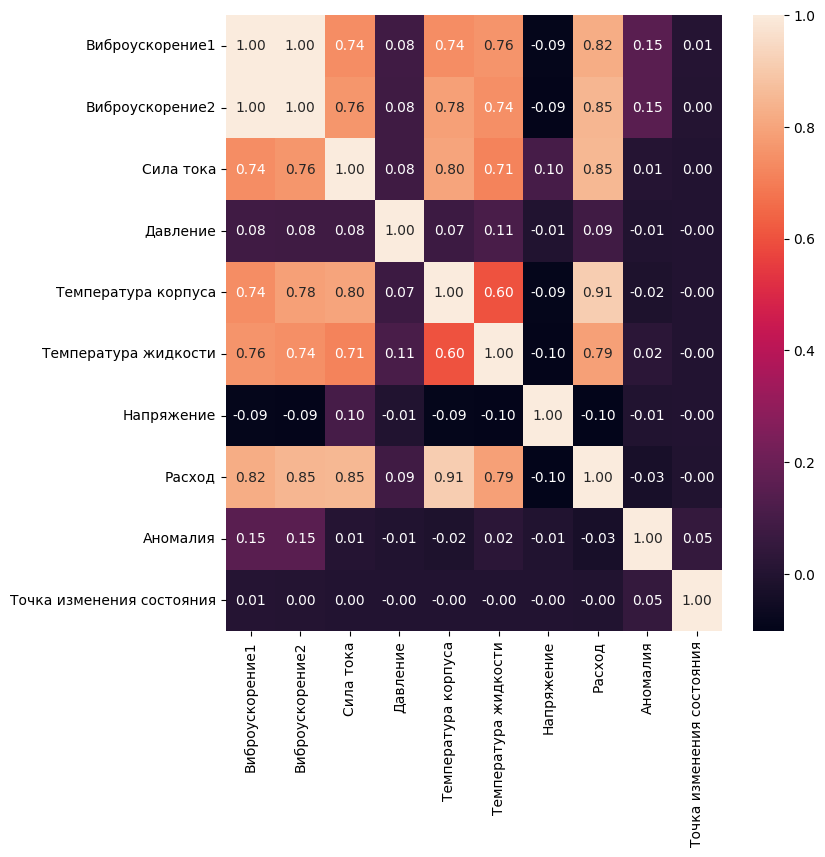

In [53]:
plt.figure(figsize=(8, 8))
display(Markdown('__Данные за весь период:__'))
sns.heatmap(alldata.corr(), annot = True, fmt='.2f');

Наблюдения:
* Высокая отрицательная корреляция между расходом и целевой переменной, а также температурой и целевой переменной для датасета "valve1" эксперимент №2
* Значение коэффициента корреляции между сигналами в отдельных датасетах отличается друг от друга и от корреляции за весь период
* Наблюдаются высокие положительные корреляции между отдельными признаками в каждом из датасетов (Виброускорения между собой, Температуры между собой, Расход с параметрами виброускорения, силы тока, температуры)

<a id="2.3"></a>
## 3.6 Анализ признаков
В этом разделе проводится более детальный анализ каждого сигнала

<a id="2.3.1"></a>
### 3.6.1 Расход

В первую очередь, для анализа параметров бывает полезным посмотреть на распределение значений с помощью гистограммы

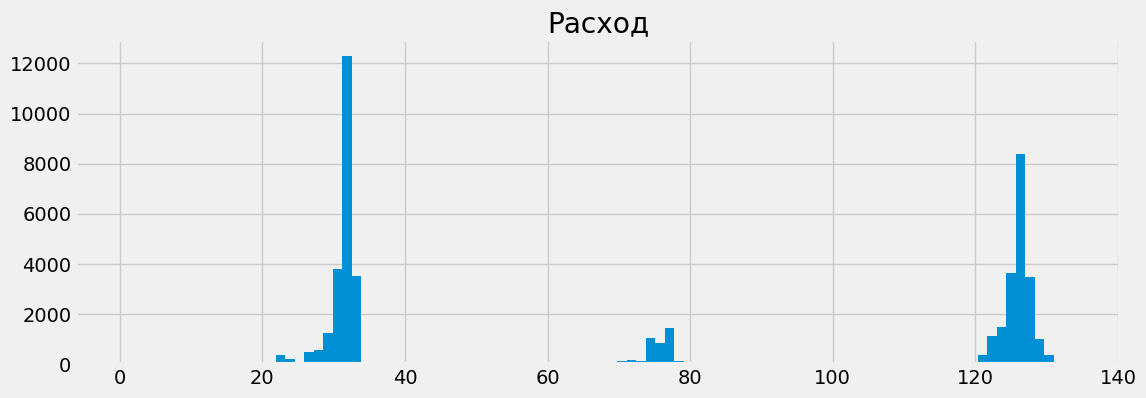

In [54]:
fast_hist(alldata['Расход'], title='Расход', n=100)

По распределению можно выделить 3 основных режима. 

Построим тренды расхода для каждого отдельного дня, при этом значения в аномальные режиммы работы будут выделены красным цветом

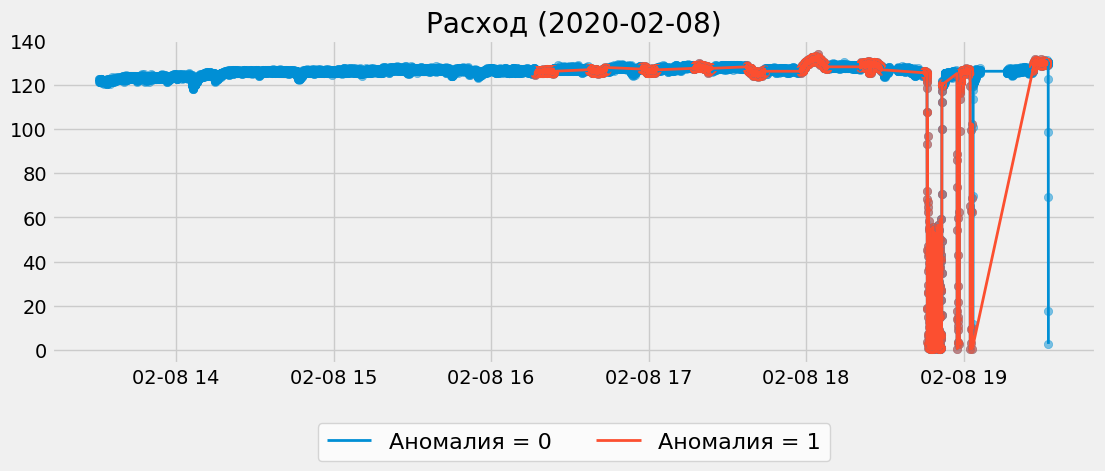

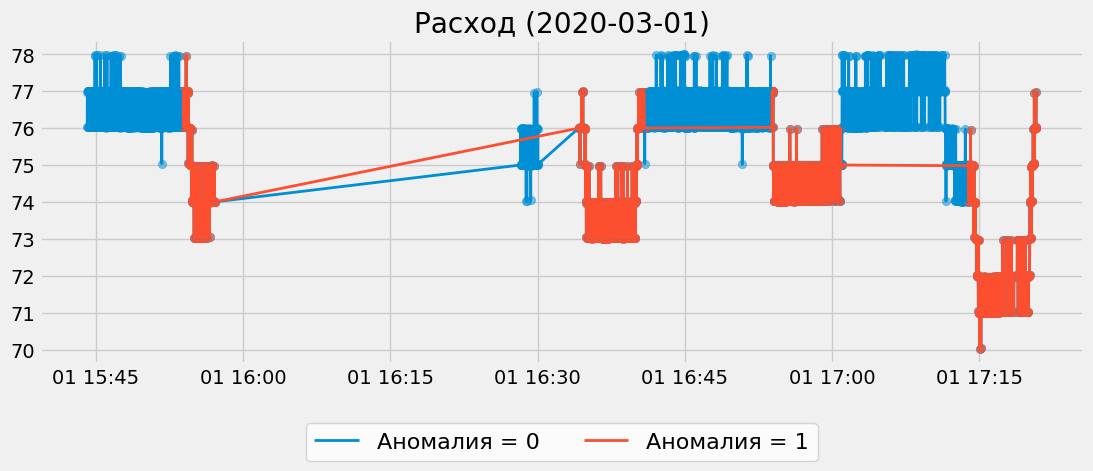

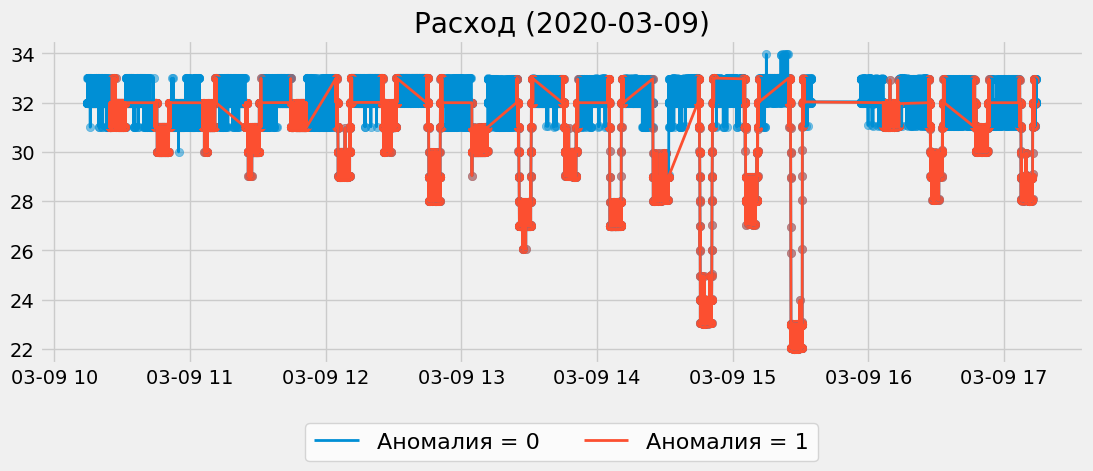

In [55]:
fast_plot(alldata['Расход']['2020-02-08'], title='Расход (2020-02-08)', label='Аномалия = 0')
mask = alldata['Аномалия']['2020-02-08'] == 1
fast_plot(alldata['Расход']['2020-02-08'][mask], new_figure=False, label='Аномалия = 1')
fast_legend()

fast_plot(alldata['Расход']['2020-03-01'], title='Расход (2020-03-01)', label='Аномалия = 0')
mask = alldata['Аномалия']['2020-03-01'] == 1
fast_plot(alldata['Расход']['2020-03-01'][mask], new_figure=False, label='Аномалия = 1')
fast_legend()

fast_plot(alldata['Расход']['2020-03-09'], title='Расход (2020-03-09)', label='Аномалия = 0')
mask = alldata['Аномалия']['2020-03-09'] == 1
fast_plot(alldata['Расход']['2020-03-09'][mask], new_figure=False, label='Аномалия = 1')
fast_legend();

Можно отметить, что в периоды падения расхода, наблюдаются аномальные режимы работы оборудования

Рассмотрим 15 самых часто встречаемых значений расхода на 9 марта

In [56]:
alldata['Расход']['2020-03-09'].value_counts().head(15)

Расход
32.0000    8326
31.0000     825
29.0000     665
33.0000     536
30.0000     519
27.0000     339
28.0000     146
24.0000     125
23.0000     101
30.0002      61
30.9998      60
32.0126      50
32.0134      50
32.9877      50
32.9875      49
Name: count, dtype: int64

> __Гипотезы:__
> * Снижение расхода (в рамках одного режима работы) часто свидетельствует о зарождении аномалии

<a id="2.3.2"></a>
### 3.6.2 Вибросукорения
Виброускорения можно рассматривать в паре для обоих точек измерения

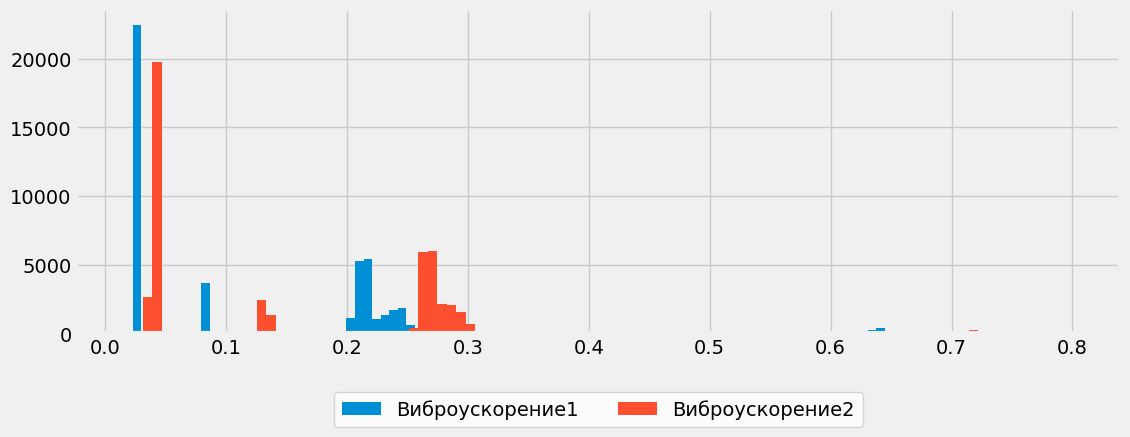

In [57]:
fast_hist(alldata['Виброускорение1'], title='Виброускорения', n=100, label='Виброускорение1')
fast_hist(alldata['Виброускорение2'], new_figure=False, n=100, label='Виброускорение2')
fast_legend(fontsize=14);

Наблюдения:
* Величина виброускорения во второй точке в среднем выше чем в первой.

Построим диаграмму рассеивания для двух точек виброускорения

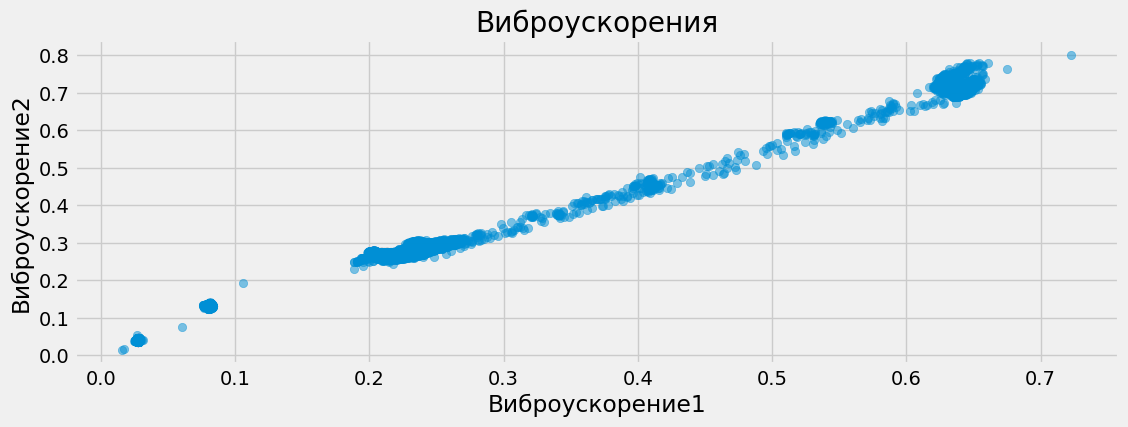

In [66]:
fast_scatter(alldata['Виброускорение1'], alldata['Виброускорение2'], title='Виброускорения')
plt.xlabel('Виброускорение1')
plt.ylabel('Виброускорение2');

In [67]:
# Корреляция значений виброускорений
alldata[['Виброускорение1', 'Виброускорение2']].corr()

Виброускорение1  Виброускорение2
Виброускорение1         1.000000         0.996434
Виброускорение2         0.996434         1.000000

> __Гипотеза:__
> * Так как корреляция значений виброускорений очень близка к 1, значения близки и измеряют одни и те же параметры, хорошим вариантом будет из двух признаков выбрать 1, а второй заменить на разницу между этими двумя параметрами

Построим тренды виброускорений в точке 1 для каждого отдельного дня, при этом значения в аномальные режимы работы будут выделены красным цветом

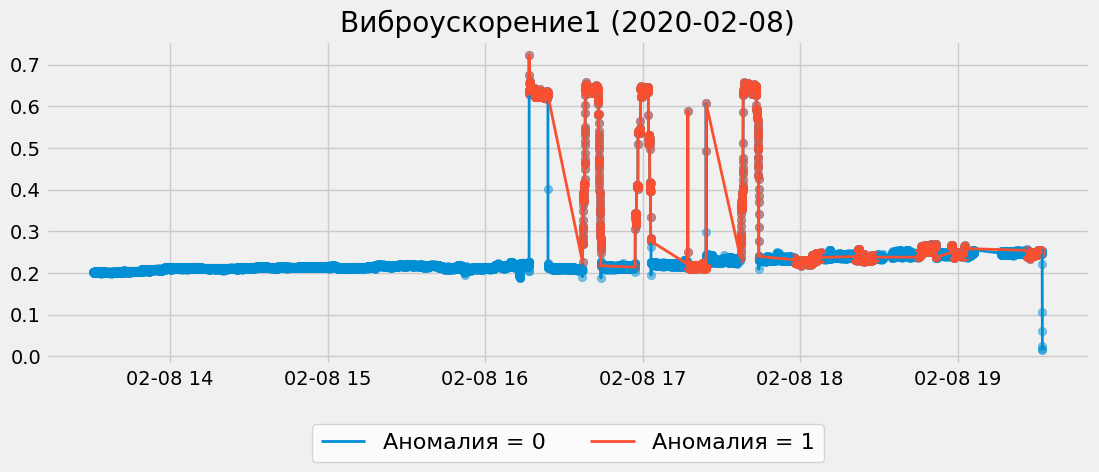

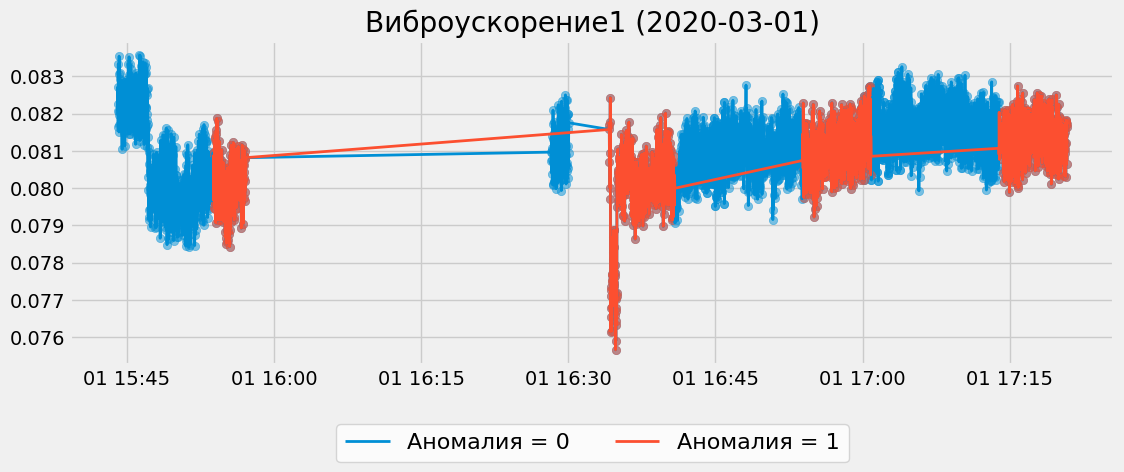

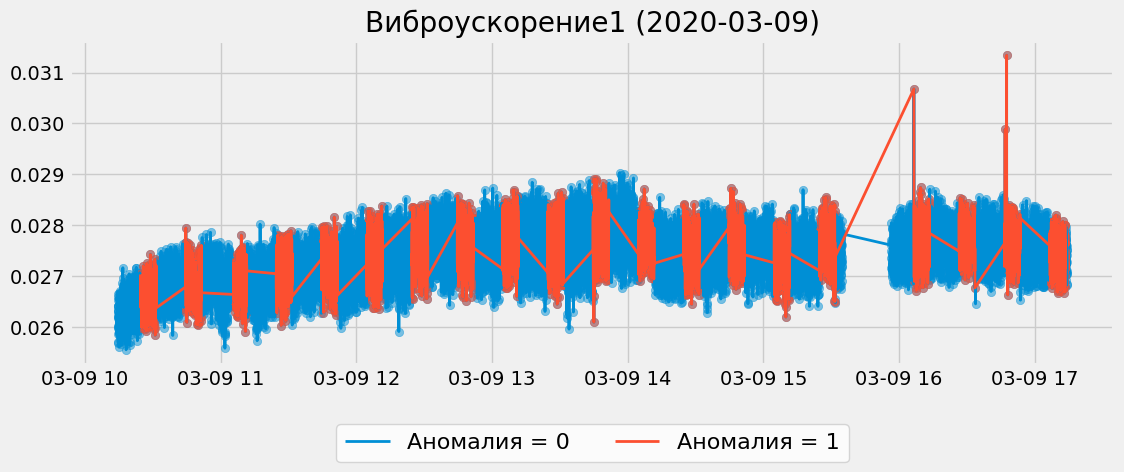

In [60]:
mask = alldata['Аномалия']['2020-02-08'] == 1
fast_plot((alldata['Виброускорение1'])['2020-02-08'], title='Виброускорение1 (2020-02-08)', label='Аномалия = 0')
fast_plot((alldata['Виброускорение1'])['2020-02-08'][mask], new_figure=False, label='Аномалия = 1')
fast_legend();

mask = alldata['Аномалия']['2020-03-01'] == 1
fast_plot((alldata['Виброускорение1'])['2020-03-01'], title='Виброускорение1 (2020-03-01)', label='Аномалия = 0')
fast_plot((alldata['Виброускорение1'])['2020-03-01'][mask], new_figure=False, label='Аномалия = 1')
fast_legend();

mask = alldata['Аномалия']['2020-03-09'] == 1
fast_plot((alldata['Виброускорение1'])['2020-03-09'], title='Виброускорение1 (2020-03-09)', label='Аномалия = 0')
fast_plot((alldata['Виброускорение1'])['2020-03-09'][mask], new_figure=False, label='Аномалия = 1')
fast_legend();

Построим такой же график для периода с 2020-02-08 16:00 по 18:00

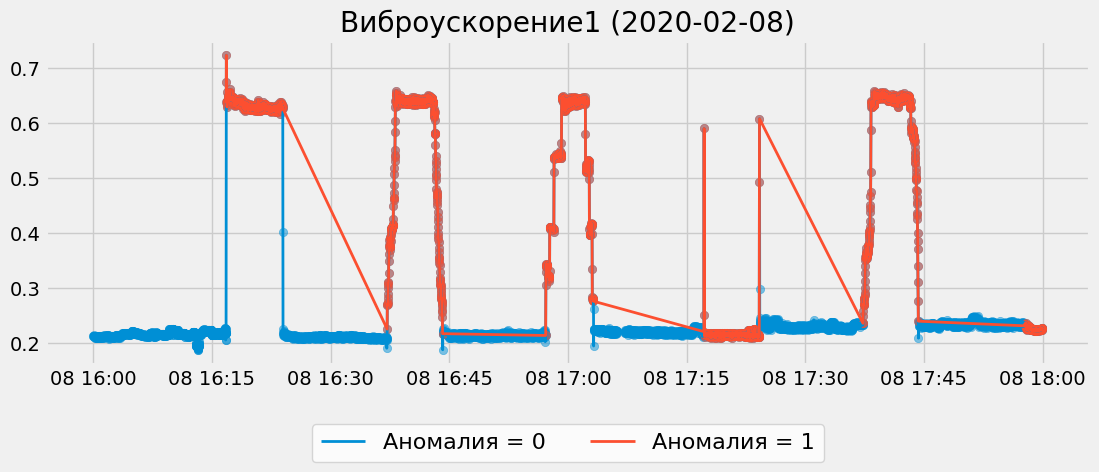

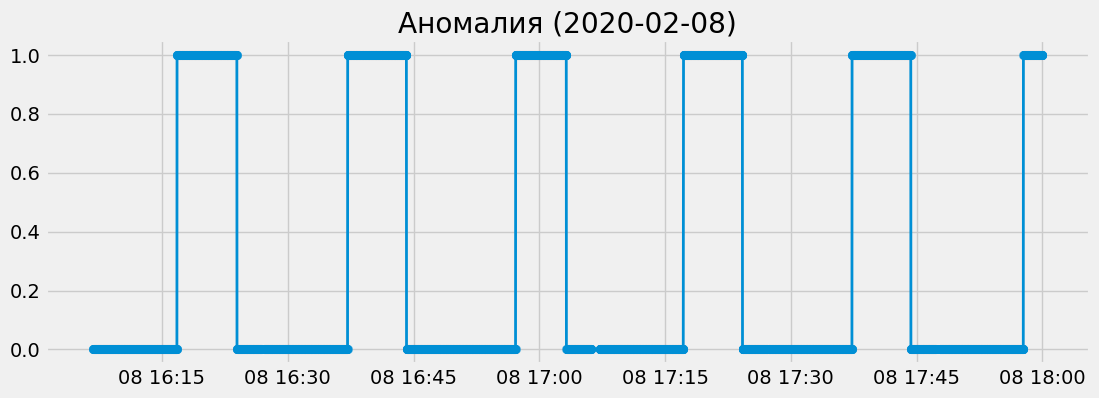

In [61]:
mask = alldata['Аномалия']['2020-02-08 16' : '2020-02-08 17'] == 1
fast_plot((alldata['Виброускорение1'])['2020-02-08 16' : '2020-02-08 17'], title='Виброускорение1 (2020-02-08)',
          label='Аномалия = 0')
fast_plot((alldata['Виброускорение1'])['2020-02-08 16' : '2020-02-08 17'][mask], new_figure=False, label='Аномалия = 1')
fast_legend();

fast_plot((alldata['Аномалия'])['2020-02-08 16' : '2020-02-08 17'], title='Аномалия (2020-02-08)', label='Аномалия = 0')

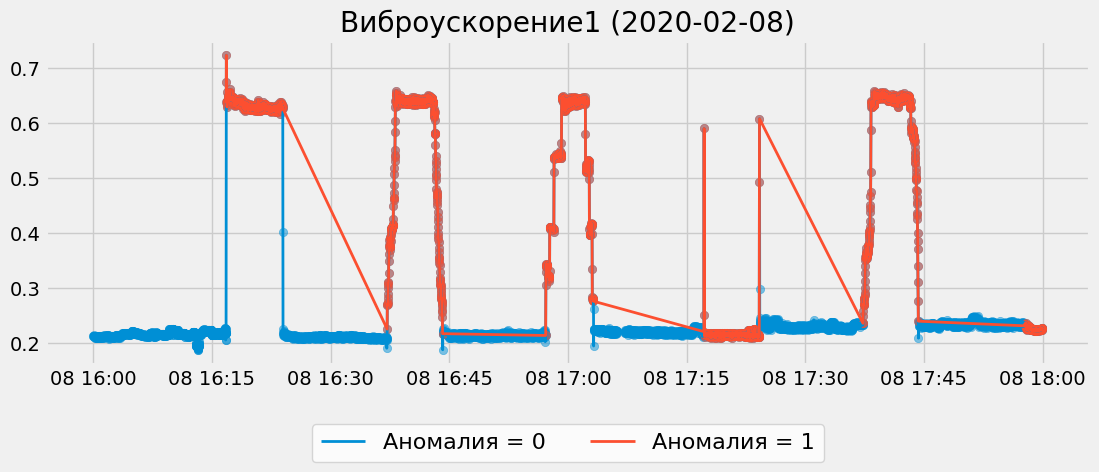

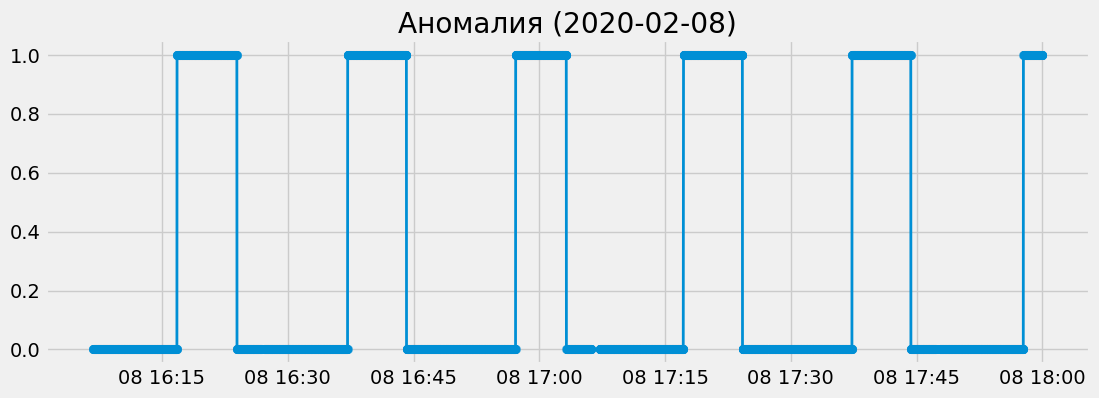

In [62]:
mask = alldata['Аномалия']['2020-02-08 16' : '2020-02-08 17'] == 1
fast_plot((alldata['Виброускорение1'])['2020-02-08 16' : '2020-02-08 17'], title='Виброускорение1 (2020-02-08)',
          label='Аномалия = 0')
fast_plot((alldata['Виброускорение1'])['2020-02-08 16' : '2020-02-08 17'][mask], new_figure=False, label='Аномалия = 1')
fast_legend();

fast_plot((alldata['Аномалия'])['2020-02-08 16' : '2020-02-08 17'], title='Аномалия (2020-02-08)', label='Аномалия = 0')

Можно отметить, что и нормальный и аномальный периоды содержат в себе высокие значения вибрации.


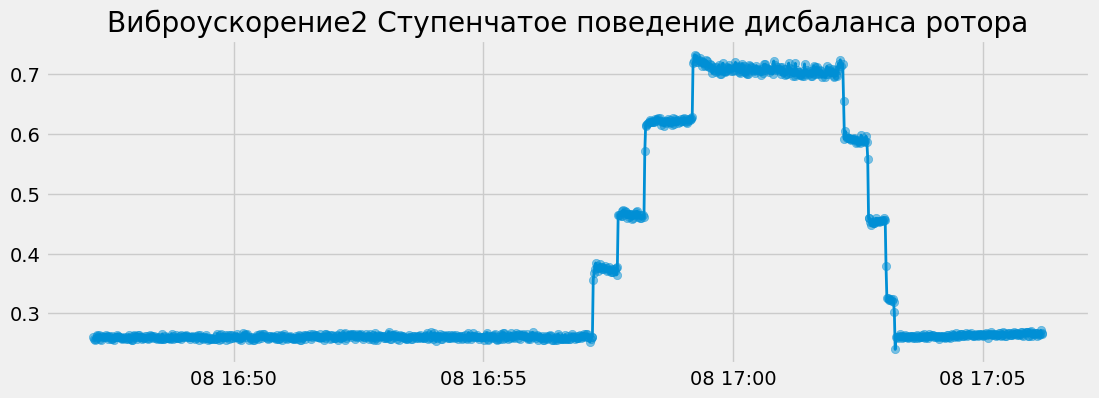

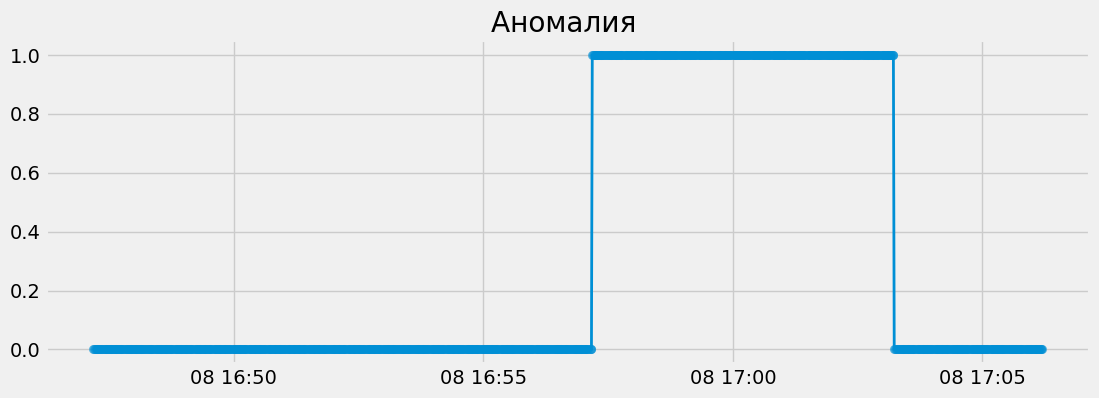

In [63]:
data = pd.read_csv('/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/7.csv', sep=';',
                   index_col='datetime', parse_dates=True)

data.columns = cols_names
fast_plot(data['Виброускорение2'], title='Виброускорение2 Ступенчатое поведение дисбаланса ротора'  )
fast_plot(data['Аномалия'], title='Аномалия ')

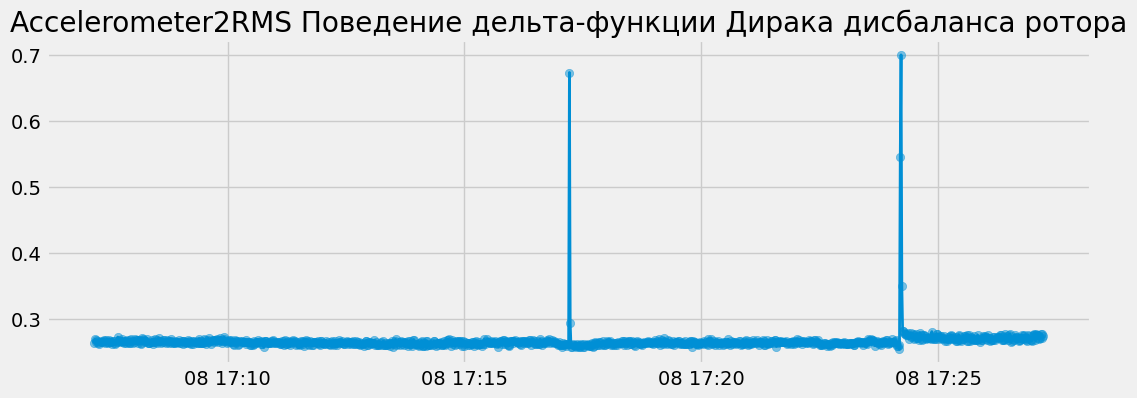

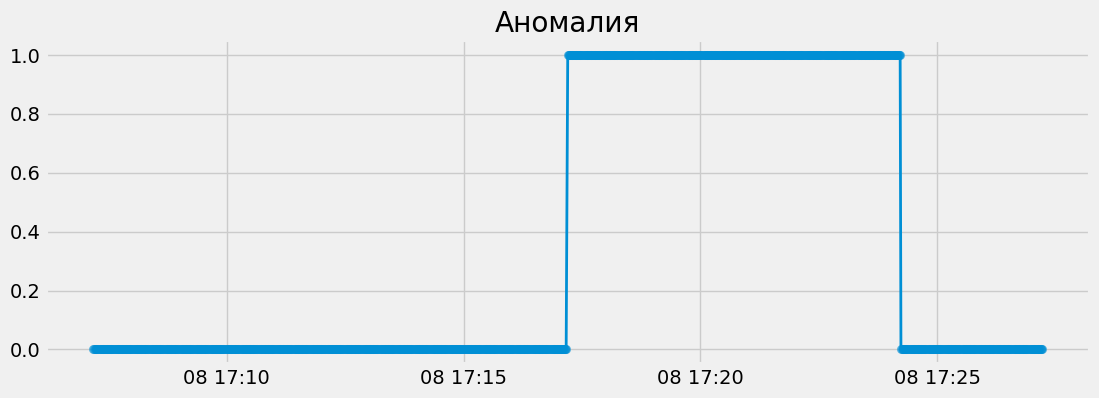

In [64]:
data = pd.read_csv('/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/8.csv', sep=';', index_col='datetime', parse_dates=True)
data.columns = cols_names

fast_plot(data['Виброускорение2'], title='Accelerometer2RMS Поведение дельта-функции Дирака дисбаланса ротора')
fast_plot(data['Аномалия'], title='Аномалия')

Посмотрим на случаи, связанные с падением расхода на дату 2020-02-08

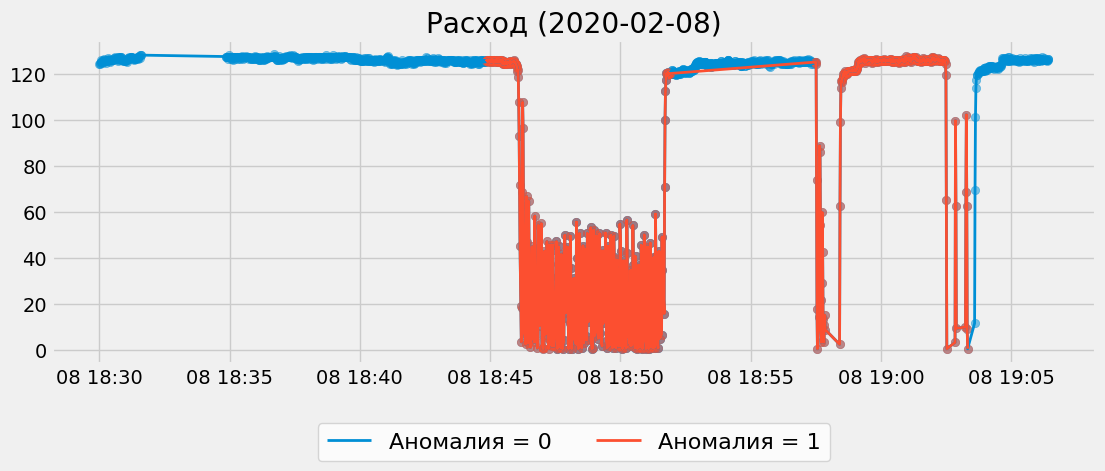

In [65]:
fast_plot(alldata['Расход']['2020-02-08 18:30': '2020-02-08 19:15'], title='Расход (2020-02-08)',
          label='Аномалия = 0')
mask = alldata['Аномалия']['2020-02-08 18:30': '2020-02-08 19:15'] == 1
fast_plot(alldata['Расход']['2020-02-08 18:30': '2020-02-08 19:15'][mask], new_figure=False,
          label='Аномалия = 1')
fast_legend();

# TODO
Провести анализ оставшихся признаков (сила тока, напряжение, давление, температуры...) и посмотреть какие признаки стоит, а какие не стоит добавлять в выборку для обучения модели

# 4. Результаты

В результате проведенного разведочного анализа данных можно сделать следующие выводы:

    1. Во всех имеющихся данных не было обнаружено пропусков.
    2. Некоторые признаки имеют нереальные значения (к примеру Для давления наблюдались отрицательные значения (min = -1.257000). ). Необходима дальнейшая фильтрация данных.
    3. Снижение расхода (в рамках одного режима работы) часто свидетельствует о зарождении аномалии.
    4. Целевое время проведения экспериментов около 20 минут, для anomaly_free время проведения составило 2 часа 46 минут
    5. Процент времени с аномальным состоянием находится в диапазоне от 25.23% до 50%, но для основной части это значение находится в районе 35%
    6. Для большинства экспериментов записано 4 точки изменения состояния.
    7. Эксперименты проводились в следующие даты: 2020-02-08, 2020-03-01, 2020-03-09
    8. Так как корреляция значений виброускорений очень близка к 1, значения близки и измеряют одни и те же параметры, хорошим вариантом будет из двух признаков выбрать 1, а второй заменить на разницу между этими двумя параметрами. То же может касаться температур.
    
В результате анализа описательных статистик по различным экспериментам можно сказать следующее:    
    
    Среднее значение виброускорения для anomaly free почти на порядок выше чем для экспериментов с закрытием входных и выходных клапанов (valve1[0], valve2[0])
    Среднее значение расхода воды для anomaly free в 4 раза выше чем для экспериментов с закрытием входных и выходных клапанов (valve1[0], valve2[0])
    Средние значения температуры, давления, тока, термопары для anomaly free выше чем для экспериментов с закрытием входных и выходных клапанов (valve1[0], valve2[0])

    
   
    Следующие шаги по подготовке данных:
    1. Фильтрация данных (очистка от отрицательных и нереальных значений, возможна очистка от выбросов)
    2. Генерация дополнительных признаков
